## Лабораторная работа №6 "Проведение исследований с моделями классификации"

Загружаем необходимые для выполнения лабораторной работы библиотеки.

In [3]:
import lib_6
import os
import shutil
import kagglehub
import torch
import time
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchvision import models
from torchvision.models import ViT_B_16_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

В качестве набора данных был выбран датасет "Clothes Dataset", содержащий 7500 изображений предметов одежды, разделенных на 15 классов (для каждого класса 500 изображений). Скачать датасет можно по ссылке: https://www.kaggle.com/datasets/ryanbadai/clothes-dataset. В нем представлены следующие классы: блейзер, брюки, шорты, платье, толстовка, куртка, джинсовая куртка, спортивная куртка, джинсы, футболка, рубашка, пальто, поло, юбка, свитер.

Изображения в данном наборе данных отражают разнообразные стили, текстуры и цвета, что делает его ценным ресурсом для обучения моделей распознавания и классификации категорий одежды. Этот набор идеально подходит для решения задач, таких как **создание систем рекомендаций в модной индустрии, разработка приложений для виртуальной примерки или анализ визуальных тенденций в электронной торговле модой**.

Описанные использования результатов обучения моделей на рассматриваемом датасете **актуальны в контексте роста электронной торговли и использования технологий искусственного интеллекта для улучшения пользовательского опыта в модной индустрии**. Системы рекомендаций, основанные на анализе изображений одежды, позволяют персонализировать покупки и предлагать пользователям товары, которые соответствуют их стилю и предпочтениям. Виртуальная примерка одежды, в свою очередь, позволяет покупателям оценить, как предметы одежды будут выглядеть на них без необходимости примерять их физически, что улучшает процесс покупок онлайн. Кроме того, анализ визуальных тенденций помогает брендам и магазинам предсказывать популярные стили и адаптировать свои коллекции в соответствии с предпочтениями покупателей, что является ключевым фактором для успешной торговли и увеличения продаж.



В **задаче многоклассовой классификации** важно учитывать не только общее количество верных предсказаний (Accuracy), но и то, насколько сбалансировано и точно модель работает по всем классам. Поэтому используются несколько **метрик**, каждая из которых даёт свой угол обзора на поведение модели.

1. Loss (Train Loss)
* Что показывает: Насколько модель "уверена" в своих предсказаниях.
* Зачем нужен: Это основная метрика оптимизации. Потери уменьшаются — значит модель учится.
* Важно: Низкий loss ≠ хорошее качество на тесте, но без него невозможна тренировка.

2. Accuracy
* Что показывает: Доля правильных предсказаний от общего числа.
* Почему не всегда достаточно: В случае несбалансированных классов может быть обманчивой. Например, если один класс преобладает, модель может «угадывать» только его и иметь высокую accuracy, но плохо работать с остальными.

3. Precision
* Что показывает: Среди всех предсказаний класса — сколько действительно правильные?
* Почему важна: Помогает понять, насколько модель «аккуратно» делает предсказания — особенно важно, если ложные срабатывания критичны.

4. Recall
* Что показывает: Из всех объектов нужного класса — сколько модель нашла?
* Почему важен: Важно в задачах, где нужно не пропустить ни одного нужного примера (например, при диагностике).

5. F1-score
* Что показывает: Гармоническое среднее между precision и recall.
* Почему критически важен: Учитывает как точность, так и полноту, и особенно полезен при несбалансированных классах.
* F1 лучше показывает реальное качество классификации, чем просто accuracy.

6. Матрица ошибок (confusion matrix)
* Что показывает: Подробное распределение ошибок по всем классам — кто с кем путается.
* Почему незаменима: Помогает выявить слабые места модели:
* Часто ли путаются определённые пары классов?
* Есть ли полностью игнорируемые классы?
* Работает ли модель "локально", например, путая похожие классы?

**Необходимо использовать набор метрик, а не одну, потому что:**
* Каждая метрика дополняет общую картину.
* В многоклассовой задаче особенно важно не упустить слабые классы.
* F1, Precision и Recall позволяют оценивать модель честно и глубоко, особенно при несбалансированных данных.

Скачиваем датасет в стандартную директорию, а после перемещаем его по нужному нам пути.

In [5]:
path = kagglehub.dataset_download("ryanbadai/clothes-dataset")

new_path = '/content/1/'

if not os.path.exists(new_path):
    os.makedirs(new_path)

shutil.move(path, new_path)

print(f"Path to dataset files: {new_path}")

100%|██████████| 1.37G/1.37G [00:15<00:00, 93.9MB/s]

Extracting files...


Path to dataset files: /content/1/


Разделяем набор изображений одежды на обучающую и тестовую выборки. Для этого сначала создаем необходимые директории для хранения обучающих и тестовых данных. Затем для каждого класса (категории одежды) из исходного набора данных создаем соответствующие папки для обучающей и тестовой выборок. Далее изображения из каждого класса случайным образом разделяем на две группы: 80% для обучения и 20% для тестирования. Изображения перемещаем в соответствующие папки для обучения и тестирования.

In [ ]:
dataset_path = '/content/1/clothes-dataset/Clothes_Dataset/'

train_dir = '/content/1/train'
test_dir = '/content/1/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = os.listdir(dataset_path)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        images = os.listdir(class_path)

        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in test_images:
            shutil.move(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Датасет разделен на обучающую и тестовую выборки.")

Датасет разделен на обучающую и тестовую выборки.


Проверяем доступность GPU для ускорения вычислений. В случае недоступности GPU будет использован CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Настраиваем предварительную обработку изображений и загрузку данных для обучения и тестирования модели. В transform создается последовательность преобразований для изображений:

1. Resize — изменение размера изображений до 224x224 пикселей, что соответствует входному размеру для большинства моделей;

2. ToTensor — преобразование изображений в тензоры для использования в PyTorchУ

3. Normalize — нормализация изображений с использованием заранее заданных средних значений и стандартных отклонений для каждого канала (R, G, B).

В train_dataset и test_dataset создаются объекты для загрузки обучающих и тестовых данных из папок, используя класс ImageFolder и применяя указанные преобразования.

В train_loader и test_loader создаются загрузчики данных (DataLoader), которые позволяют эффективно загружать данные пакетами (batch). Размер пакета установлен на batch_size = 32 (по 32 изображения в каждом пакете). Для обучающего набора данных включен механизм случайной перемешки данных (shuffle=True), а для тестового набора — нет (shuffle=False).

Для тестового набора данных отключен shuffle (перемешивание данных), потому что:

* Оценка производительности модели: Когда мы оцениваем модель на тестовых данных, важно, чтобы каждый элемент тестового набора был обработан в том же порядке, в котором он был передан. Перемешивание данных может привести к случайному порядку, что затруднит воспроизведение результатов и корректную оценку модели. Мы хотим, чтобы результаты тестирования были стабильно повторяемыми.

* Консистентность: Отключение перемешивания гарантирует, что каждый запуск тестирования будет использовать один и тот же порядок данных, что упрощает анализ результатов и позволяет проводить более точные сравнения между различными моделями или параметрами.

In [ ]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Загружаем предобученную **сверточную модель** VGG16, которая является одной из самых известных и эффективных моделей для задач классификации изображений. Модель VGG16 состоит из 16 слоев (13 сверточных и 3 полносвязных), что позволяет ей извлекать глубокие и детализированные признаки из изображений. Выбр пал на эту модель, поскольку известно, что она показывает отличные результаты на задачах классификации, таких как ImageNet, и является достаточно универсальной для адаптации под различные задачи.

Для адаптации модели под выбранный набор данных заменяем его на линейный слой с количеством выходных нейронов, равным числу классов в обучающем наборе данных. Затем переносим модель на доступное устройство (GPU или CPU).

Для обучения модели используем функцию потерь CrossEntropyLoss, которая хорошо подходит для многоклассовой классификации. Оптимизатор Adam настроен с маленьким значением скорости обучения (0.0001), чтобы избежать переобучения. Планировщик скорости обучения StepLR уменьшает скорость обучения на 10% каждые 5 эпох, что помогает улучшить сходимость модели в процессе обучения.

In [ ]:
vgg16_model = models.vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))
vgg16_model = vgg16_model.to(device)

vgg16_criterion = nn.CrossEntropyLoss()
vgg16_optimizer = optim.Adam(vgg16_model.parameters(), lr=0.0001)
vgg16_scheduler = optim.lr_scheduler.StepLR(vgg16_optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Запускаем обучение сверточной модели VGG16.

Epoch [1/10], Train Loss: 2.5459, Train Accuracy: 0.1592, Train F1: 0.1542, Train Precision: 0.1605, Train Recall: 0.1592
Test Accuracy: 0.2360, Test F1: 0.2049, Test Precision: 0.3274, Test Recall: 0.2360


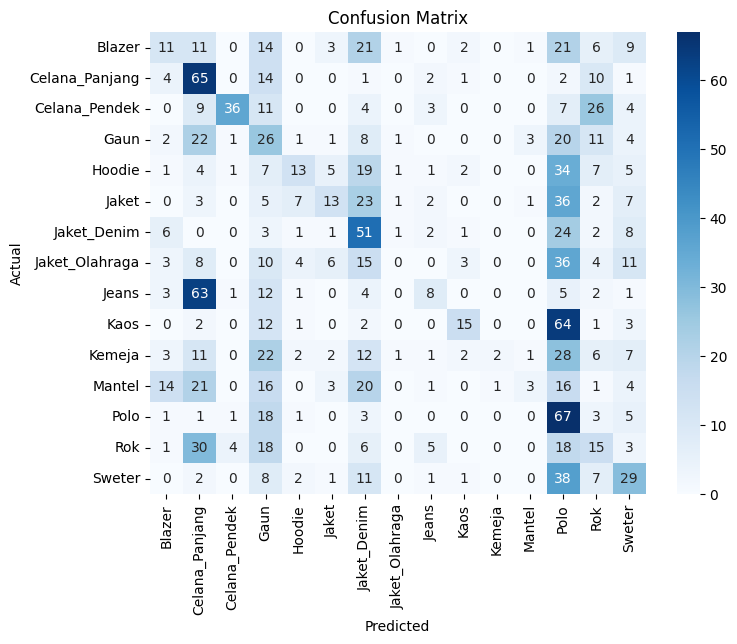

Time taken for epoch: 137.31 sec

Epoch [2/10], Train Loss: 1.8070, Train Accuracy: 0.4092, Train F1: 0.4012, Train Precision: 0.3984, Train Recall: 0.4092
Test Accuracy: 0.5053, Test F1: 0.4964, Test Precision: 0.5447, Test Recall: 0.5053


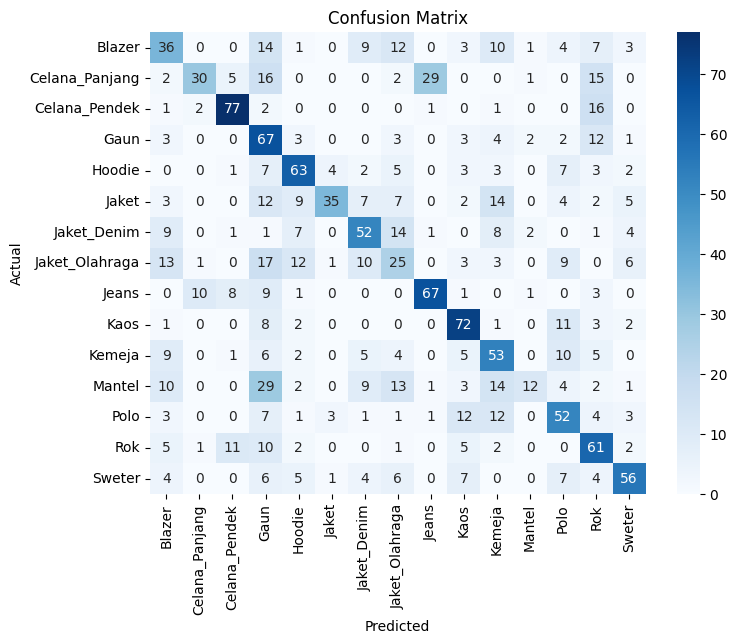

Time taken for epoch: 134.16 sec

Epoch [3/10], Train Loss: 1.3736, Train Accuracy: 0.5537, Train F1: 0.5513, Train Precision: 0.5508, Train Recall: 0.5537
Test Accuracy: 0.5920, Test F1: 0.5866, Test Precision: 0.5981, Test Recall: 0.5920


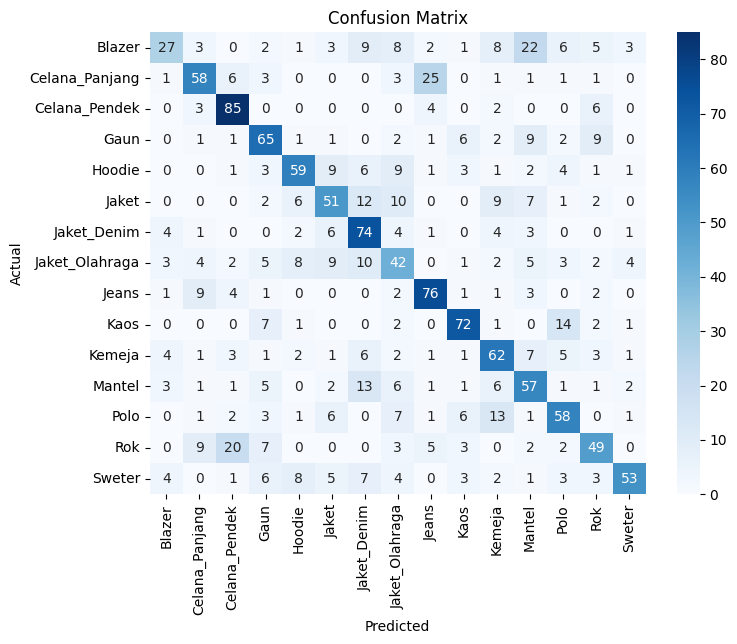

Time taken for epoch: 134.06 sec

Epoch [4/10], Train Loss: 1.1402, Train Accuracy: 0.6288, Train F1: 0.6274, Train Precision: 0.6276, Train Recall: 0.6288
Test Accuracy: 0.5913, Test F1: 0.5834, Test Precision: 0.6384, Test Recall: 0.5913


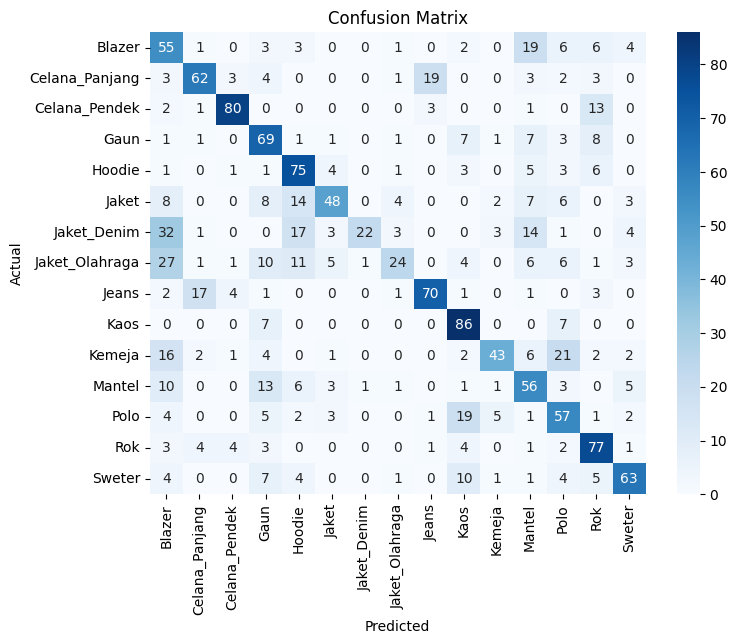

Time taken for epoch: 133.60 sec

Epoch [5/10], Train Loss: 0.9782, Train Accuracy: 0.6838, Train F1: 0.6830, Train Precision: 0.6828, Train Recall: 0.6838
Test Accuracy: 0.6340, Test F1: 0.6331, Test Precision: 0.6467, Test Recall: 0.6340


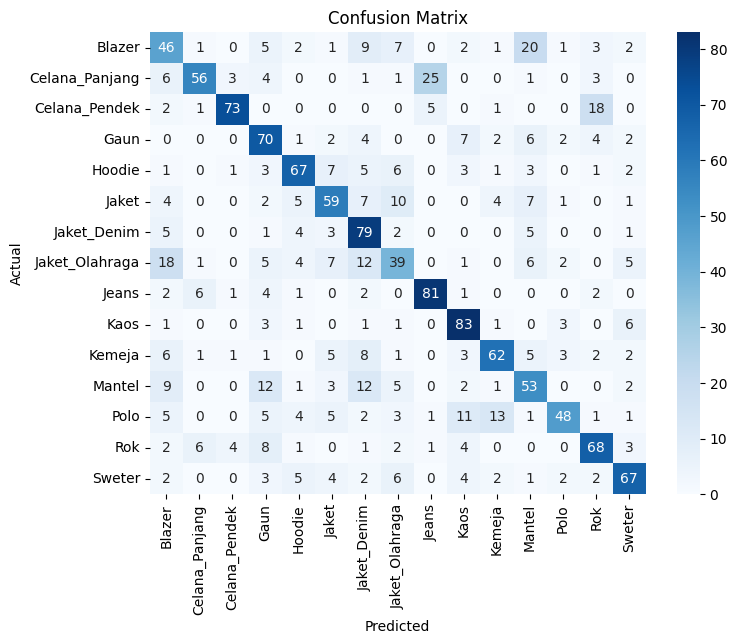

Time taken for epoch: 134.91 sec

Epoch [6/10], Train Loss: 0.5799, Train Accuracy: 0.8048, Train F1: 0.8047, Train Precision: 0.8059, Train Recall: 0.8048
Test Accuracy: 0.6860, Test F1: 0.6848, Test Precision: 0.6881, Test Recall: 0.6860


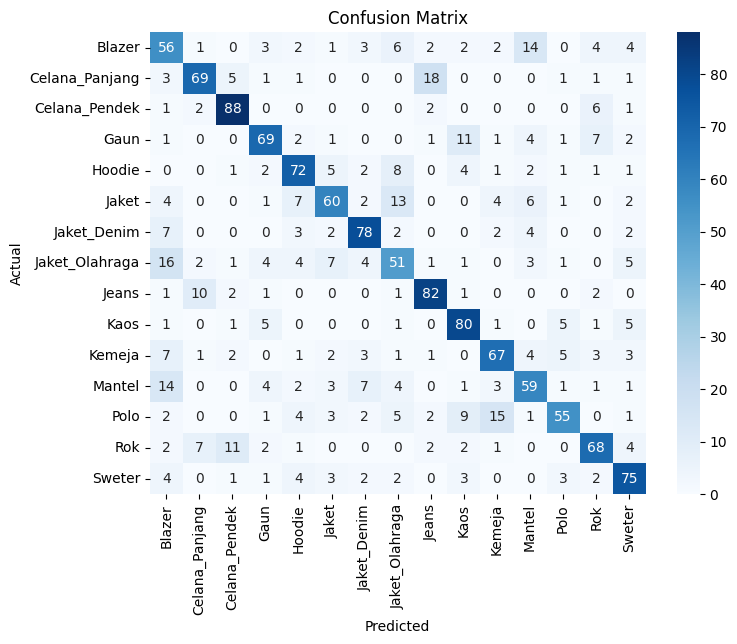

Time taken for epoch: 132.30 sec

Epoch [7/10], Train Loss: 0.4371, Train Accuracy: 0.8508, Train F1: 0.8508, Train Precision: 0.8515, Train Recall: 0.8508
Test Accuracy: 0.6920, Test F1: 0.6906, Test Precision: 0.6912, Test Recall: 0.6920


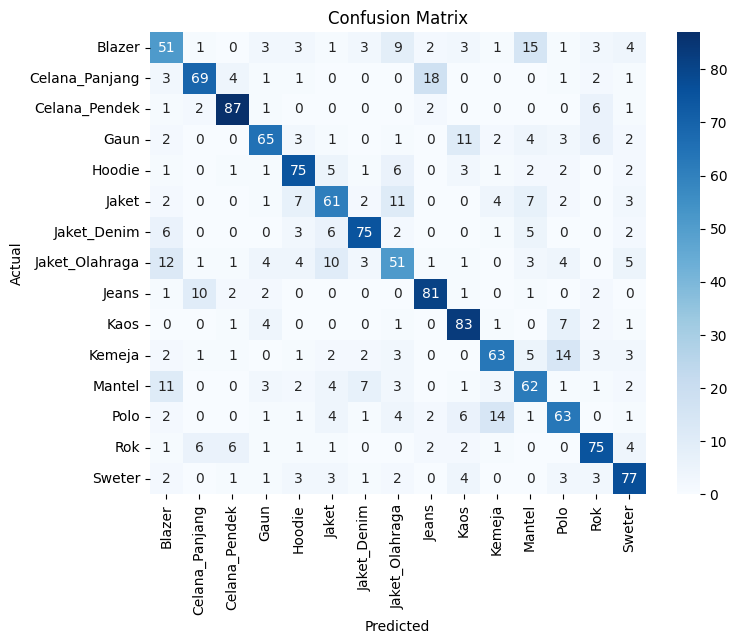

Time taken for epoch: 132.21 sec

Epoch [8/10], Train Loss: 0.3353, Train Accuracy: 0.8862, Train F1: 0.8860, Train Precision: 0.8864, Train Recall: 0.8862
Test Accuracy: 0.6913, Test F1: 0.6907, Test Precision: 0.6912, Test Recall: 0.6913


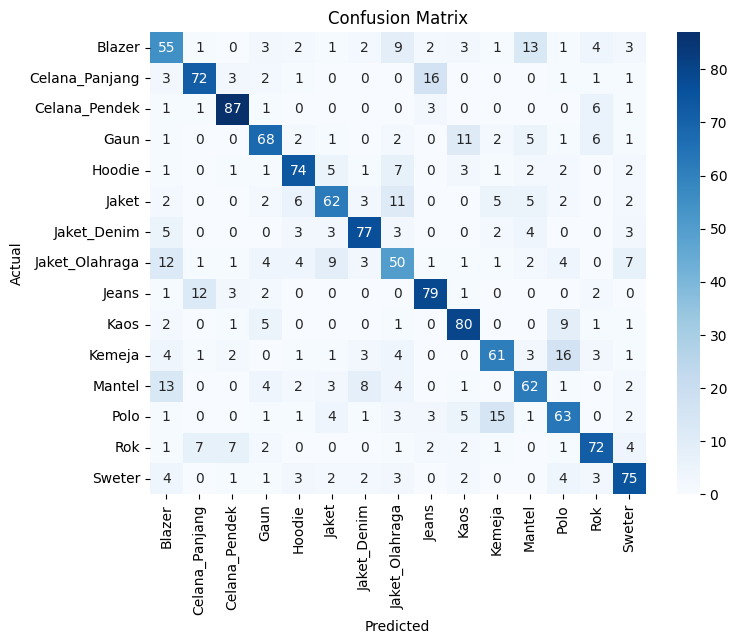

Time taken for epoch: 132.39 sec

Epoch [9/10], Train Loss: 0.2543, Train Accuracy: 0.9182, Train F1: 0.9180, Train Precision: 0.9183, Train Recall: 0.9182
Test Accuracy: 0.6840, Test F1: 0.6842, Test Precision: 0.6863, Test Recall: 0.6840


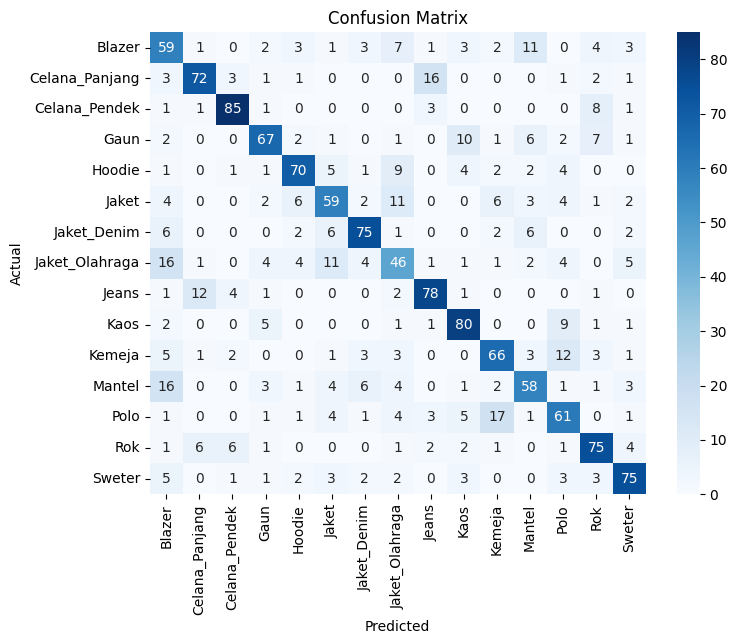

Time taken for epoch: 131.93 sec

Epoch [10/10], Train Loss: 0.1908, Train Accuracy: 0.9387, Train F1: 0.9387, Train Precision: 0.9389, Train Recall: 0.9387
Test Accuracy: 0.6833, Test F1: 0.6827, Test Precision: 0.6880, Test Recall: 0.6833


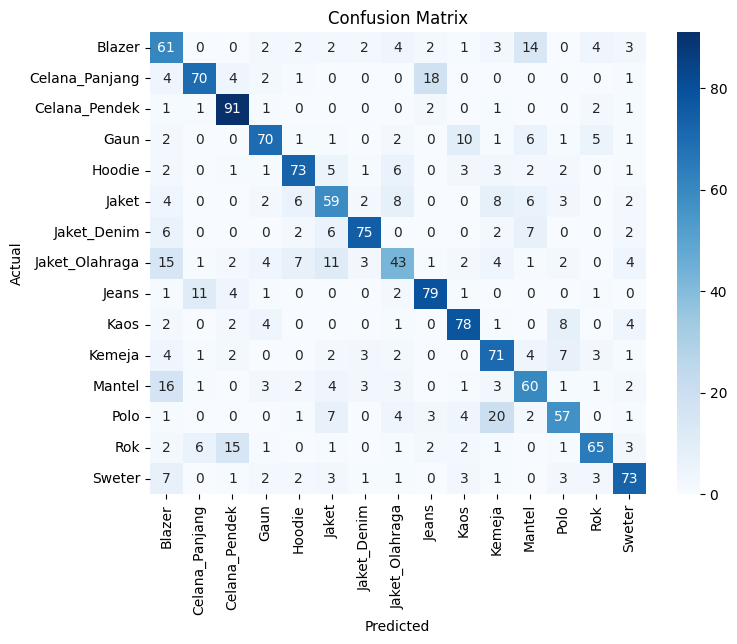

Time taken for epoch: 132.63 sec



In [ ]:
lib_6.train_model(vgg16_model, train_loader, test_loader, vgg16_criterion, vgg16_optimizer, vgg16_scheduler, test_dataset, num_epochs=10)

Проведем **анализ результатов обучения.**

**Общая картина по эпохам:**
1. Прогресс обучения (Train):
  * Train Loss стабильно снижается: с 2.5459 до 0.1908.
  * Train Accuracy растёт от 0.1592 до 0.9387.
  * Train F1/Precision/Recall синхронно растут — это говорит о сбалансированном обучении на тренировочных данных.

2. Поведение на тесте (Test):
  * Accuracy/F1 растут до 6-8-й эпохи, а затем:
  * Плато и небольшое снижение: Accuracy с пика 0.6920 опускается до 0.6833.
  * Метрики также стабилизируются, указывая на потенциальное переобучение начиная с эпохи 7–8.

**Сравнение метрик Train/Test:**

Уже с 6-й эпохи наблюдается разрыв между обучением и валидацией:
* Train Acc: 0.8048 → 0.9387
* Test Acc: 0.6860 → 0.6833

Это говорит о том, что модель всё лучше запоминает обучающие данные, но обобщающая способность не растёт, а возможно даже ухудшается.

**Возможные проблемы:**
1. Переобучение:
  * Разрыв между Train и Test метриками на последних эпохах указывает на переобучение.
  * Пик тестовой метрики — 7–8 эпоха, после чего наблюдается стагнация/падение.
2. Нерегулярное поведение в confusion matrix:
  * Классы перепутаны друг с другом (например, много ошибок между 7-м и другими классами).
  * Некоторые классы сильно путаются (например, класс 11 сильно расплывается на классы 0, 3, 4 и 6).
  * Это может говорить о дисбалансе классов, сложности различия между определёнными группами, или недостаточной репрезентации.

Загружаем предобученную **трансформенную модель** Vision Transformer ViT-B/16 с весами IMAGENET1K_V1, заменяем последний линейный слой для адаптации под текущее количество классов и переносим модель на вычислительное устройство (GPU или CPU). Выбор ViT обусловлен её высокой производительностью в задачах классификации благодаря механизму внимания, способности извлекать глобальные зависимости, а также наличием предобученных весов, что ускоряет сходимость и повышает точность на новом наборе данных. ViT-B/16 обеспечивает оптимальный баланс между вычислительными затратами и качеством результатов.

Для обучения модели используем функцию потерь CrossEntropyLoss, которая хорошо подходит для многоклассовой классификации. Оптимизатор Adam настроен с маленьким значением скорости обучения (0.0001), чтобы избежать переобучения. Планировщик скорости обучения StepLR уменьшает скорость обучения на 10% каждые 5 эпох, что помогает улучшить сходимость модели в процессе обучения.

In [ ]:
vit_model = models.vision_transformer.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit_model.heads[-1] = nn.Linear(vit_model.heads[-1].in_features, len(train_dataset.classes))
vit_model = vit_model.to(device)

vit_criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.Adam(vit_model.parameters(), lr=0.0001)
vit_scheduler = optim.lr_scheduler.StepLR(vit_optimizer, step_size=5, gamma=0.1)

Запускаем обучение трансформенной модели Vision Transformer ViT-B/16.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/10], Train Loss: 2.7375, Train Accuracy: 0.0780, Train F1: 0.0752, Train Precision: 0.0768, Train Recall: 0.0780
Test Accuracy: 0.1027, Test F1: 0.0580, Test Precision: 0.0677, Test Recall: 0.1027


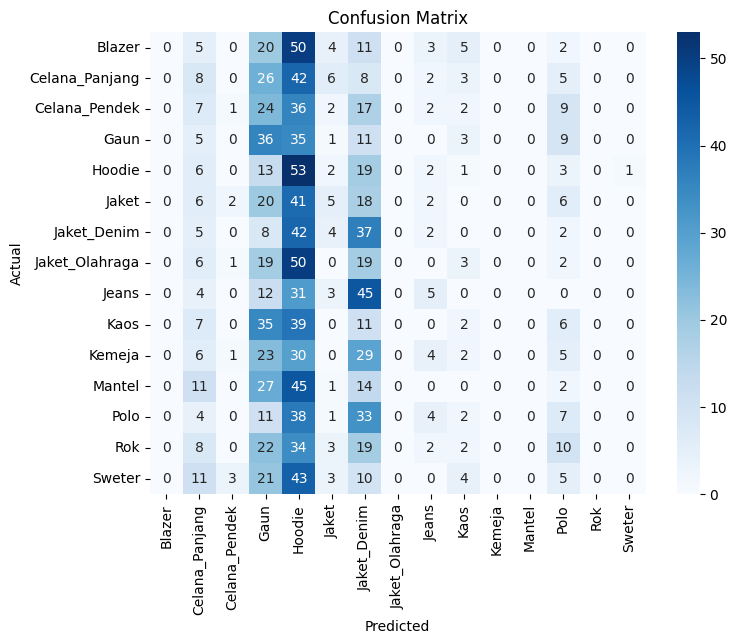

Time taken for epoch: 245.39 sec



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/10], Train Loss: 2.6586, Train Accuracy: 0.1122, Train F1: 0.1013, Train Precision: 0.1034, Train Recall: 0.1122
Test Accuracy: 0.1167, Test F1: 0.0702, Test Precision: 0.0852, Test Recall: 0.1167


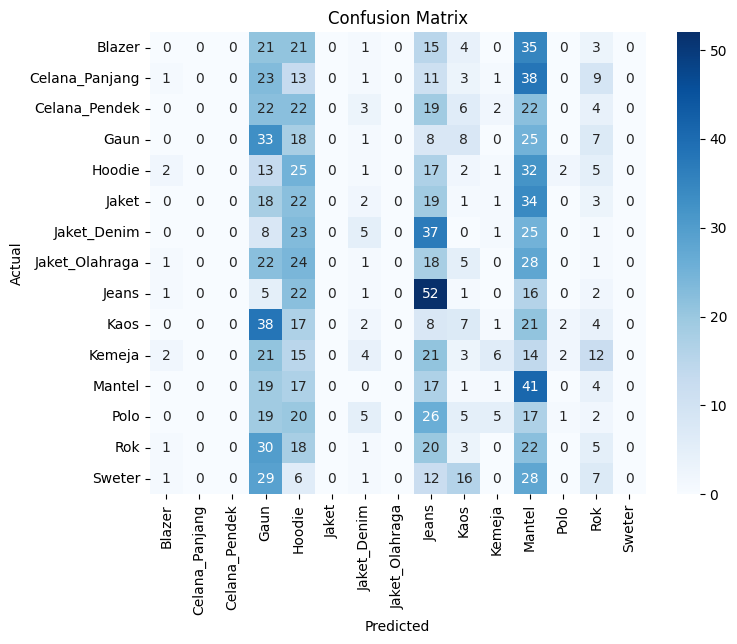

Time taken for epoch: 244.89 sec



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/10], Train Loss: 2.6036, Train Accuracy: 0.1308, Train F1: 0.1181, Train Precision: 0.1323, Train Recall: 0.1308
Test Accuracy: 0.1500, Test F1: 0.0952, Test Precision: 0.0905, Test Recall: 0.1500


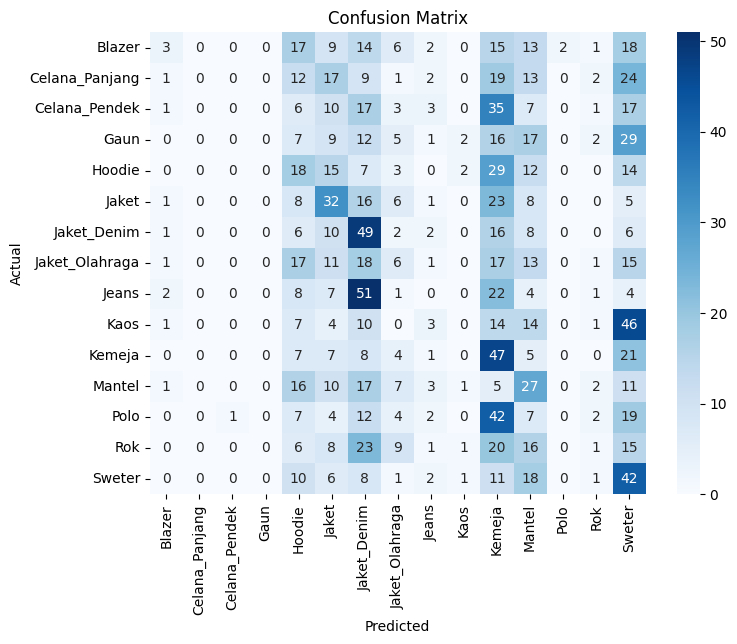

Time taken for epoch: 245.70 sec

Epoch [4/10], Train Loss: 2.5625, Train Accuracy: 0.1443, Train F1: 0.1287, Train Precision: 0.1366, Train Recall: 0.1443
Test Accuracy: 0.1473, Test F1: 0.1058, Test Precision: 0.1427, Test Recall: 0.1473


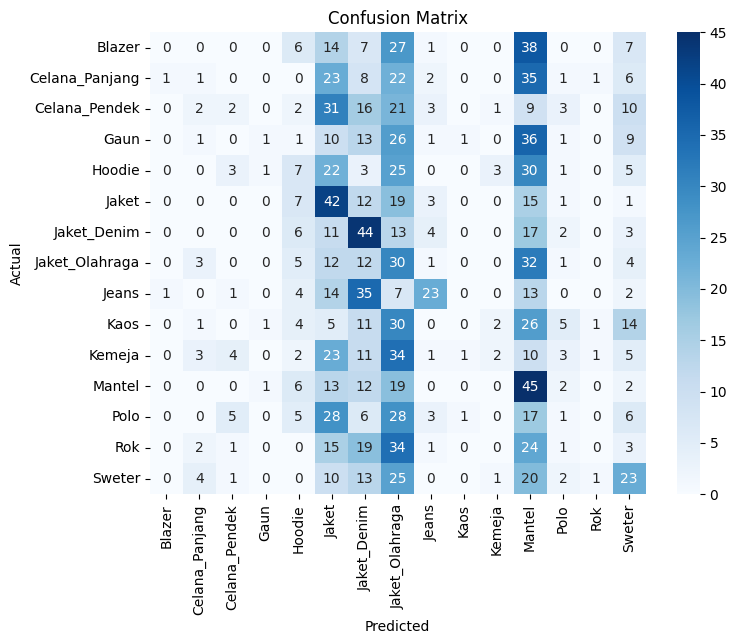

Time taken for epoch: 245.45 sec

Epoch [5/10], Train Loss: 2.4983, Train Accuracy: 0.1662, Train F1: 0.1524, Train Precision: 0.1567, Train Recall: 0.1662
Test Accuracy: 0.1633, Test F1: 0.1358, Test Precision: 0.1861, Test Recall: 0.1633


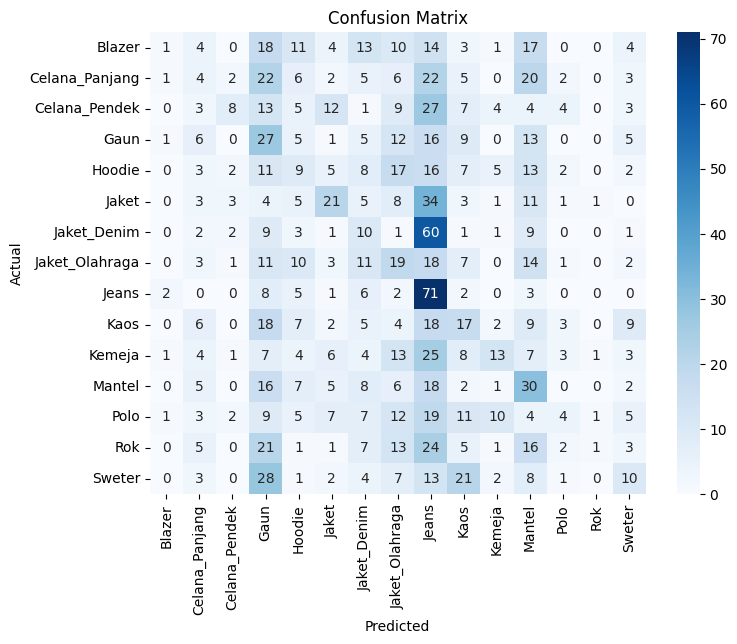

Time taken for epoch: 249.30 sec

Epoch [6/10], Train Loss: 2.3698, Train Accuracy: 0.2187, Train F1: 0.1998, Train Precision: 0.2118, Train Recall: 0.2187
Test Accuracy: 0.1967, Test F1: 0.1734, Test Precision: 0.1873, Test Recall: 0.1967


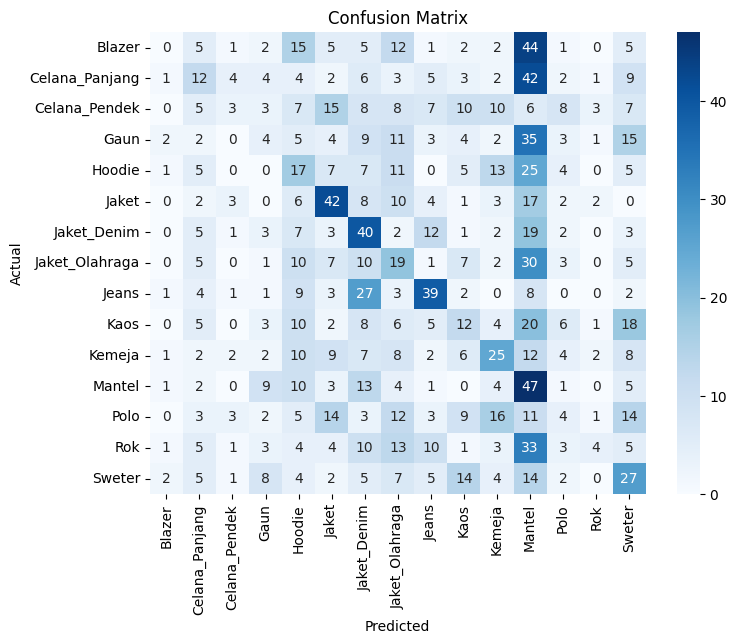

Time taken for epoch: 248.89 sec

Epoch [7/10], Train Loss: 2.3087, Train Accuracy: 0.2368, Train F1: 0.2148, Train Precision: 0.2272, Train Recall: 0.2368
Test Accuracy: 0.2180, Test F1: 0.2039, Test Precision: 0.2173, Test Recall: 0.2180


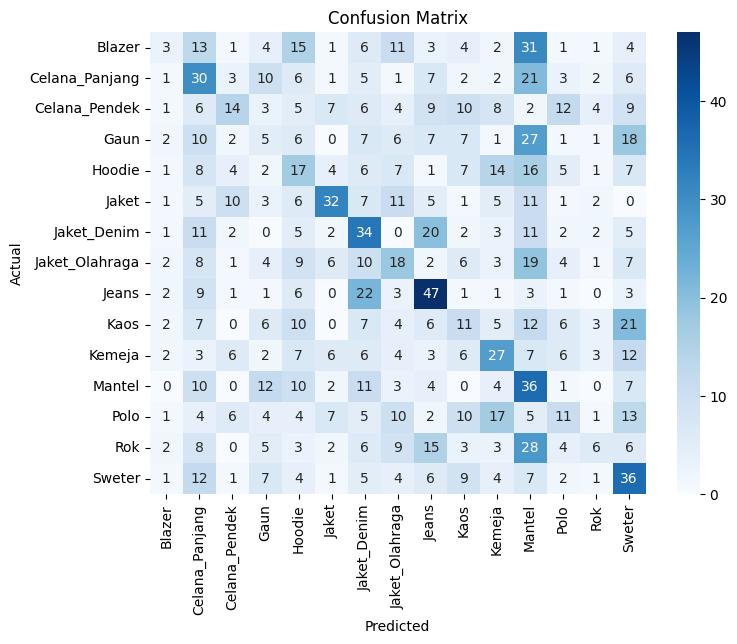

Time taken for epoch: 245.99 sec

Epoch [8/10], Train Loss: 2.2722, Train Accuracy: 0.2493, Train F1: 0.2332, Train Precision: 0.2441, Train Recall: 0.2493
Test Accuracy: 0.2227, Test F1: 0.1995, Test Precision: 0.2216, Test Recall: 0.2227


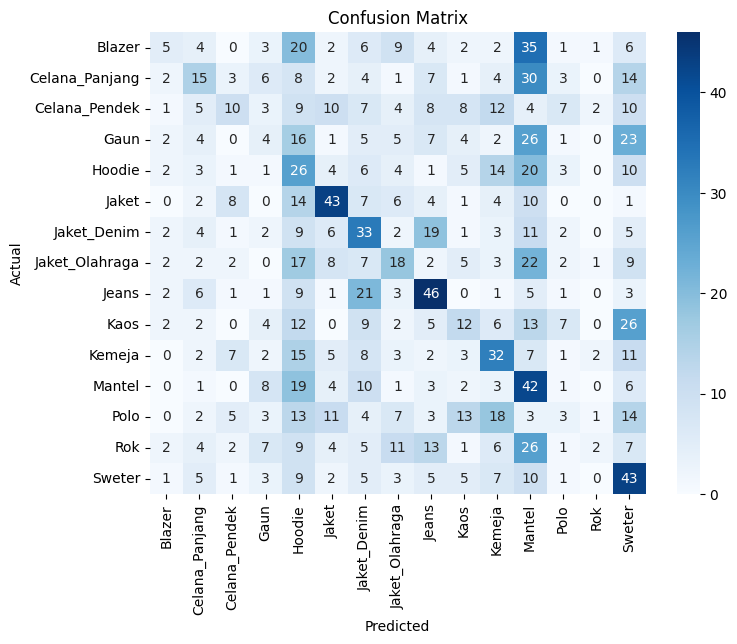

Time taken for epoch: 245.58 sec

Epoch [9/10], Train Loss: 2.2328, Train Accuracy: 0.2668, Train F1: 0.2453, Train Precision: 0.2571, Train Recall: 0.2668
Test Accuracy: 0.2280, Test F1: 0.2139, Test Precision: 0.2307, Test Recall: 0.2280


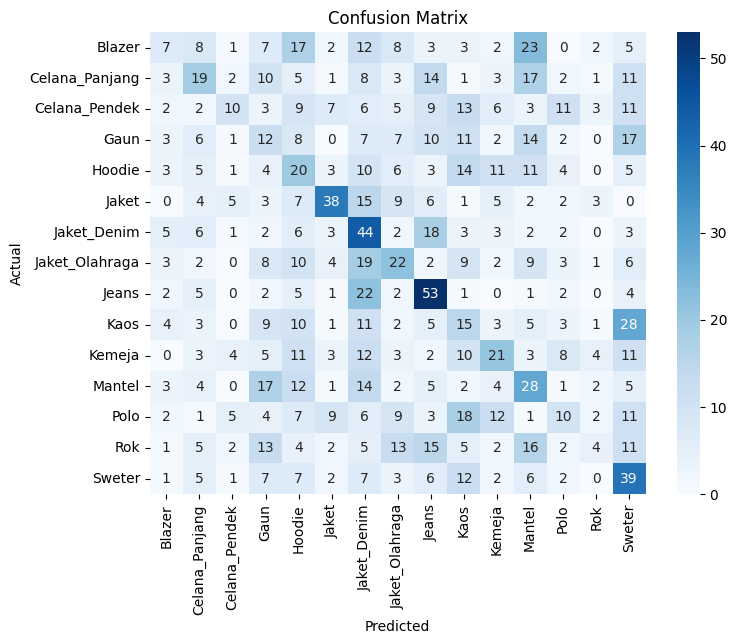

Time taken for epoch: 246.30 sec

Epoch [10/10], Train Loss: 2.1967, Train Accuracy: 0.2713, Train F1: 0.2551, Train Precision: 0.2631, Train Recall: 0.2713
Test Accuracy: 0.2420, Test F1: 0.2283, Test Precision: 0.2405, Test Recall: 0.2420


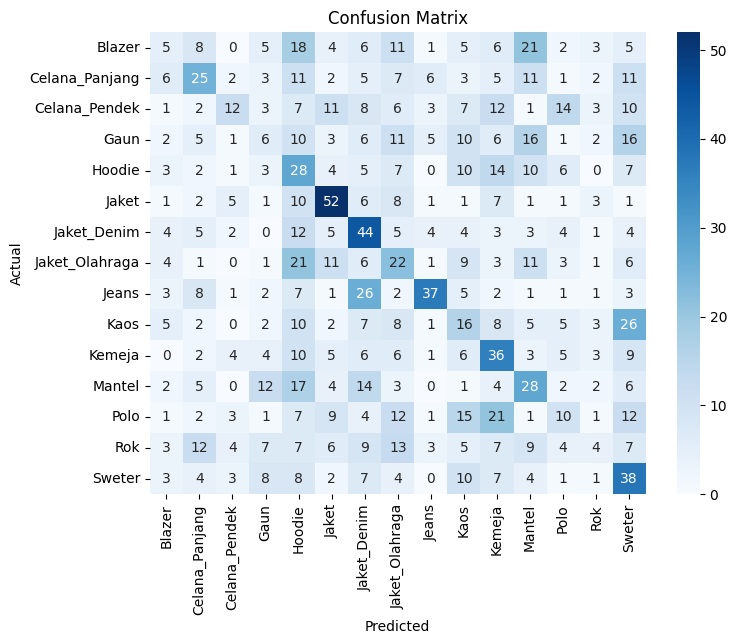

Time taken for epoch: 243.18 sec



In [ ]:
lib_6.train_model(vit_model, train_loader, test_loader, vit_criterion, vit_optimizer, vit_scheduler, test_dataset, num_epochs=10)

Проведем **анализ результатов обучения**.

**Качество обучения:**
* Прогресс есть, но очень медленный: за 10 эпох точность на тесте выросла всего с ~10% до ~24%.
* F1-score остаётся низким — особенно на ранних эпохах, что объясняет предупреждение UndefinedMetricWarning, когда некоторые классы не предсказываются вообще.

**Основные проблемы:**
* Train Loss медленно убывает: с 2.73 до 2.19
* Train Accuracy даже к концу всего ~27%

**Confusion Matrix:**
* Многие классы плохо различаются — например:
  * Класс 4 предсказывается более-менее хорошо (28), но много false positives и false negatives
  * Классы 2, 8, 10, 12, 14 — путаются почти со всеми
* Очень размытая диагональ, т.е. модель не уверена ни в чём

**Выводы:**
* ViT-B/16 обучается, но очень медленно и неэффективно
* Модель почти не "видит" классы и часто не предсказывает их вообще


Инициализируем модель CustomCNN с 15 выходными классами и переносим её на выбранное устройство. Задаём функцию потерь CrossEntropyLoss для задачи классификации. Используем оптимизатор Adam с начальными параметрами обучения. Настраиваем scheduler StepLR, чтобы каждые 7 эпох уменьшать скорость обучения в 10 раз.

In [ ]:
custom_cnn_model = lib_6.CustomCNN(num_classes=15).to(device)

custom_cnn_criterion = nn.CrossEntropyLoss()
custom_cnn_optimizer = optim.Adam(custom_cnn_model.parameters(), lr=0.001)
custom_cnn_scheduler = optim.lr_scheduler.StepLR(custom_cnn_optimizer, step_size=7, gamma=0.1)

Запускаем обучение кастомной CNN модели.

Epoch [1/10], Train Loss: 2.1834, Train Accuracy: 0.3057, Train F1: 0.3000, Train Precision: 0.3000, Train Recall: 0.3057
Test Accuracy: 0.4793, Test F1: 0.4777, Test Precision: 0.5286, Test Recall: 0.4793


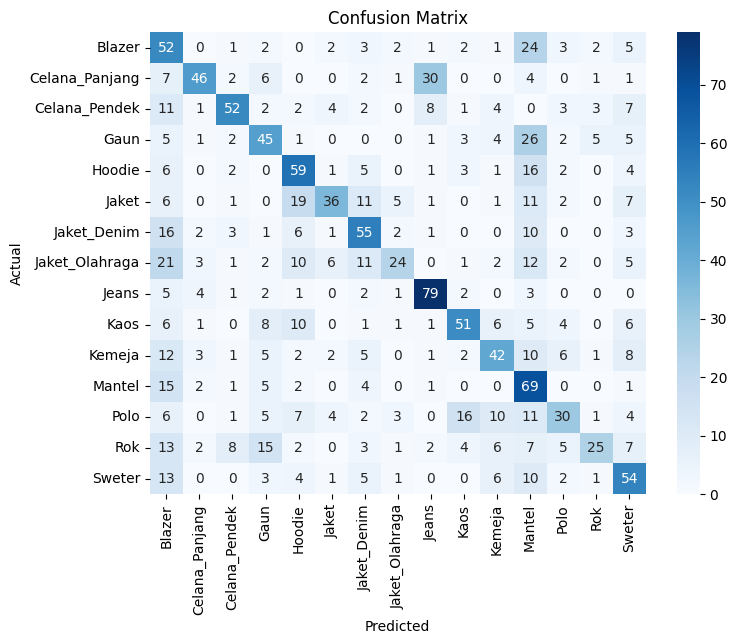

Time taken for epoch: 127.66 sec

Epoch [2/10], Train Loss: 1.4491, Train Accuracy: 0.5525, Train F1: 0.5490, Train Precision: 0.5487, Train Recall: 0.5525
Test Accuracy: 0.5560, Test F1: 0.5508, Test Precision: 0.5726, Test Recall: 0.5560


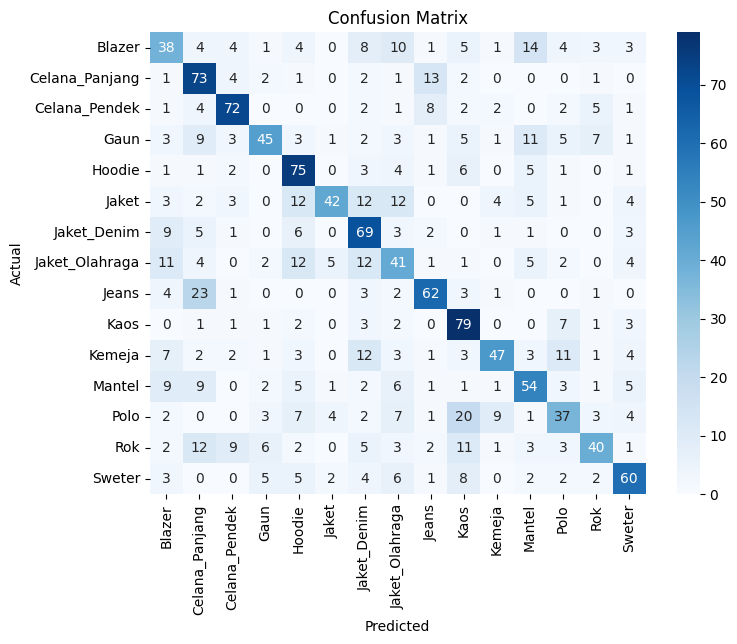

Time taken for epoch: 121.36 sec

Epoch [3/10], Train Loss: 1.0225, Train Accuracy: 0.6737, Train F1: 0.6719, Train Precision: 0.6715, Train Recall: 0.6737
Test Accuracy: 0.5687, Test F1: 0.5647, Test Precision: 0.5774, Test Recall: 0.5687


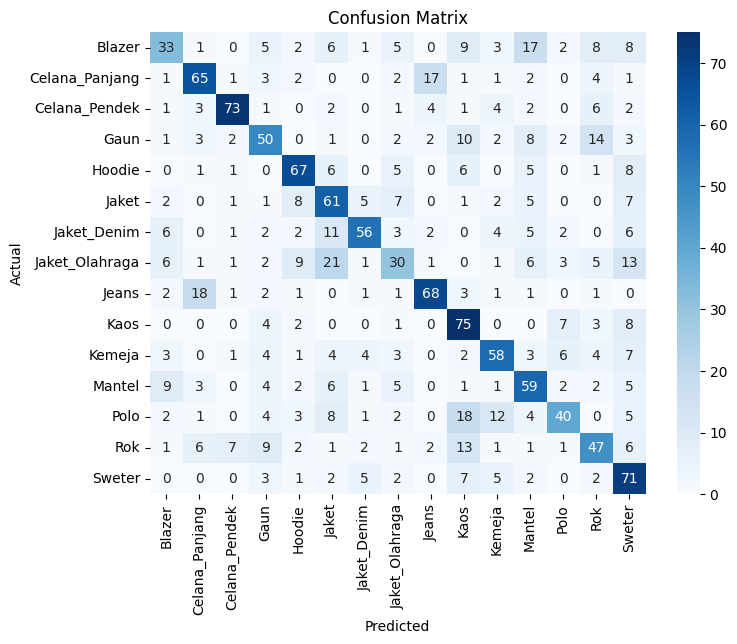

Time taken for epoch: 120.66 sec

Epoch [4/10], Train Loss: 0.6856, Train Accuracy: 0.7927, Train F1: 0.7919, Train Precision: 0.7919, Train Recall: 0.7927
Test Accuracy: 0.5847, Test F1: 0.5809, Test Precision: 0.5896, Test Recall: 0.5847


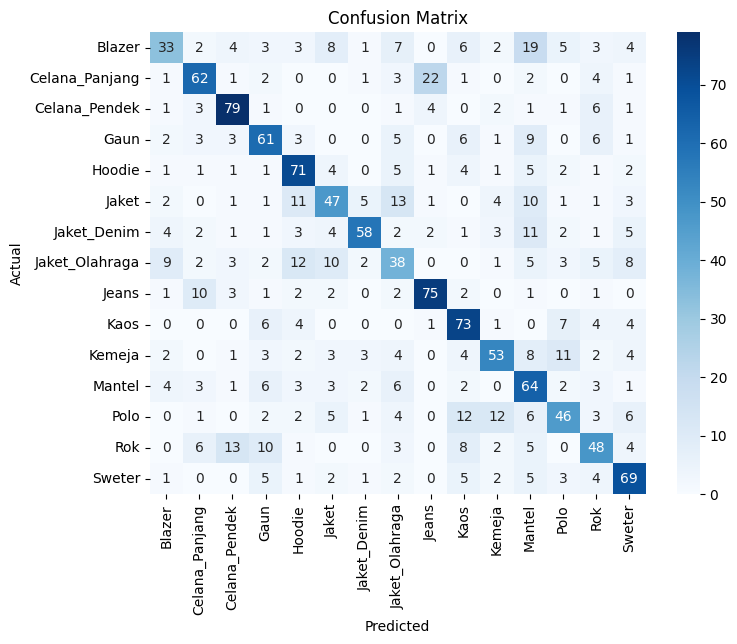

Time taken for epoch: 121.02 sec

Epoch [5/10], Train Loss: 0.3984, Train Accuracy: 0.8860, Train F1: 0.8858, Train Precision: 0.8858, Train Recall: 0.8860
Test Accuracy: 0.5953, Test F1: 0.5939, Test Precision: 0.6022, Test Recall: 0.5953


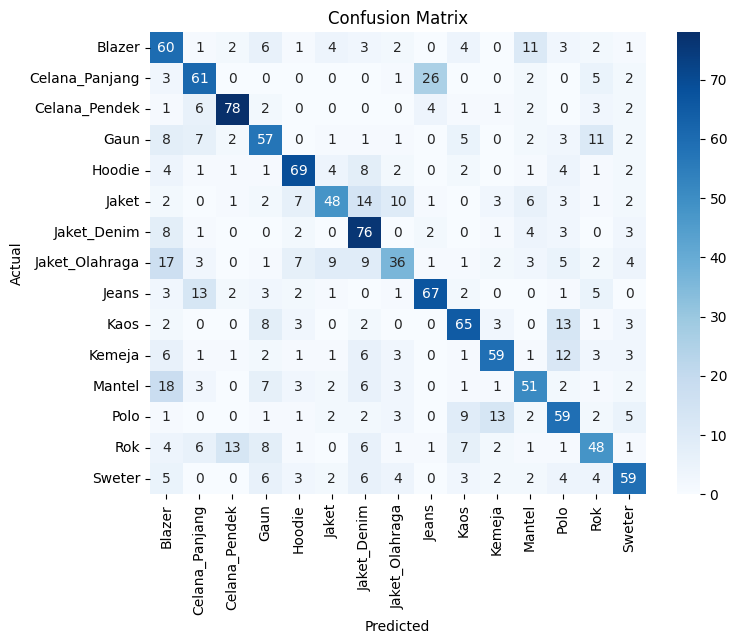

Time taken for epoch: 121.34 sec

Epoch [6/10], Train Loss: 0.2456, Train Accuracy: 0.9375, Train F1: 0.9375, Train Precision: 0.9377, Train Recall: 0.9375
Test Accuracy: 0.5947, Test F1: 0.5934, Test Precision: 0.6009, Test Recall: 0.5947


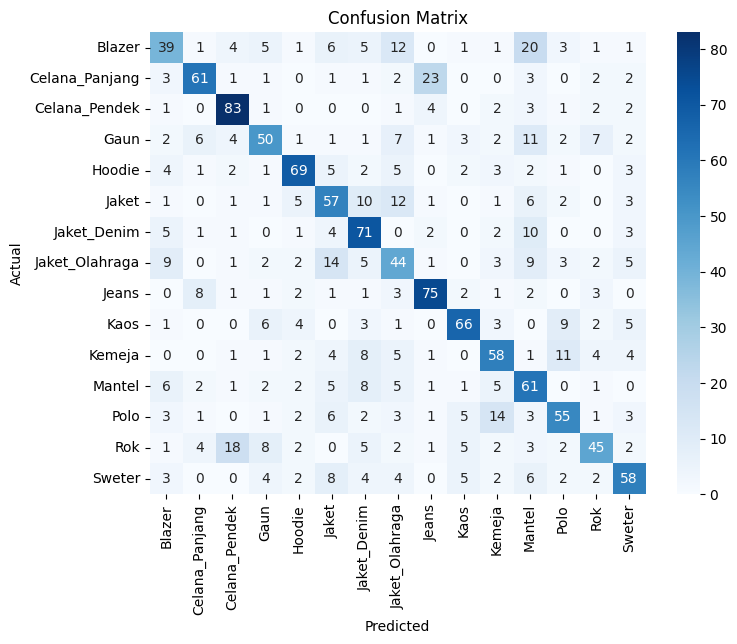

Time taken for epoch: 120.66 sec

Epoch [7/10], Train Loss: 0.1559, Train Accuracy: 0.9633, Train F1: 0.9634, Train Precision: 0.9634, Train Recall: 0.9633
Test Accuracy: 0.5920, Test F1: 0.5893, Test Precision: 0.5967, Test Recall: 0.5920


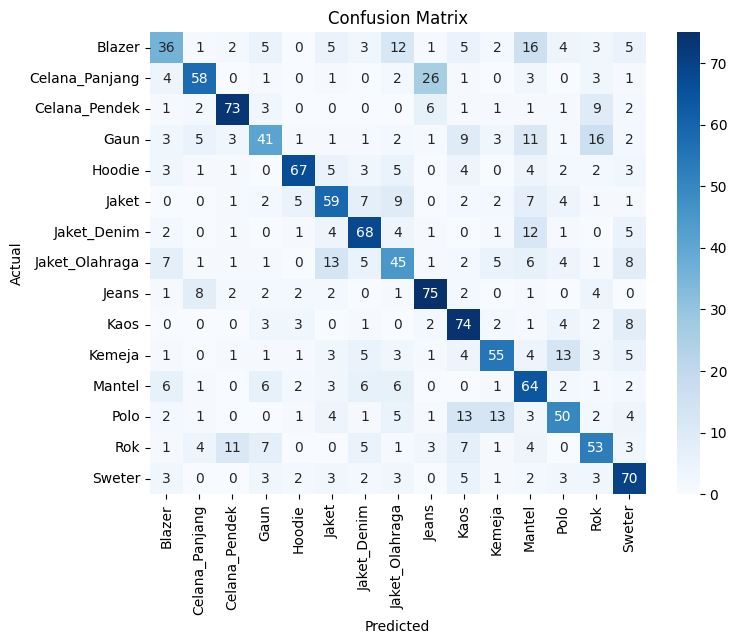

Time taken for epoch: 133.78 sec

Epoch [8/10], Train Loss: 0.0823, Train Accuracy: 0.9852, Train F1: 0.9851, Train Precision: 0.9852, Train Recall: 0.9852
Test Accuracy: 0.6160, Test F1: 0.6136, Test Precision: 0.6162, Test Recall: 0.6160


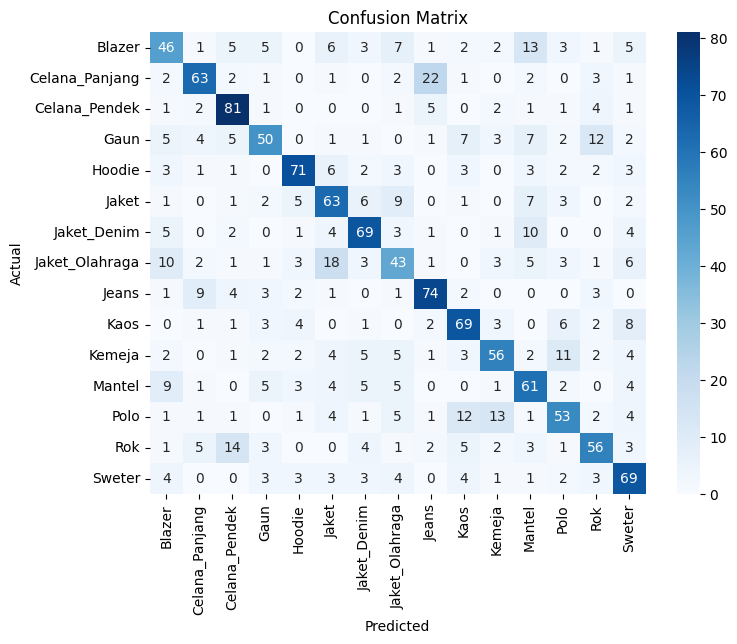

Time taken for epoch: 127.23 sec

Epoch [9/10], Train Loss: 0.0700, Train Accuracy: 0.9863, Train F1: 0.9863, Train Precision: 0.9863, Train Recall: 0.9863
Test Accuracy: 0.6133, Test F1: 0.6111, Test Precision: 0.6132, Test Recall: 0.6133


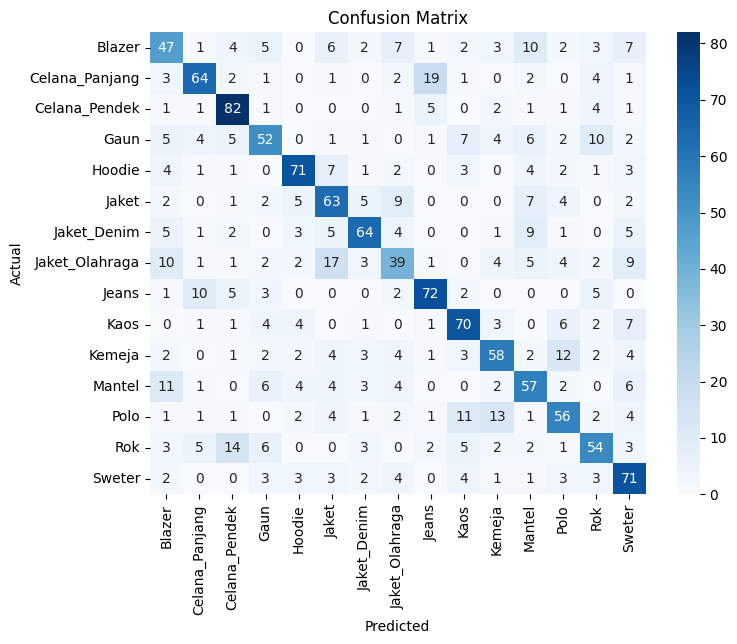

Time taken for epoch: 121.99 sec

Epoch [10/10], Train Loss: 0.0626, Train Accuracy: 0.9863, Train F1: 0.9863, Train Precision: 0.9864, Train Recall: 0.9863
Test Accuracy: 0.6153, Test F1: 0.6139, Test Precision: 0.6168, Test Recall: 0.6153


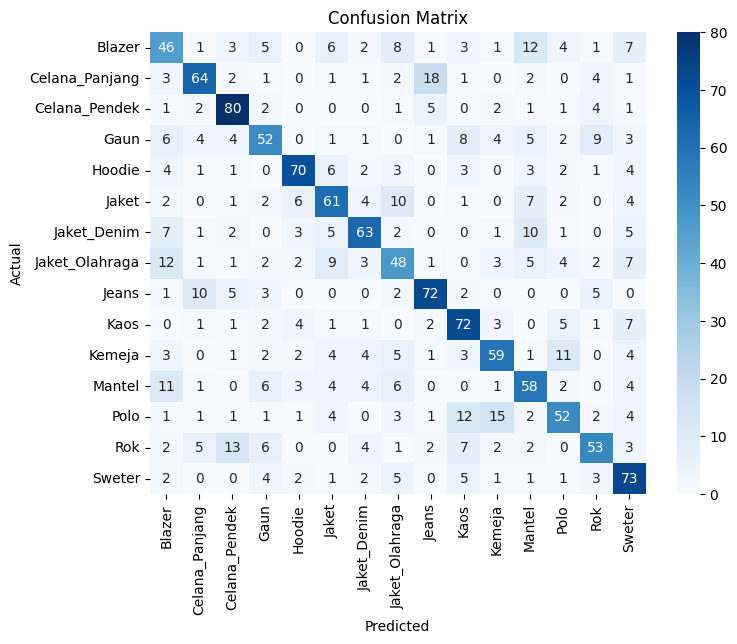

Time taken for epoch: 121.34 sec



In [ ]:
lib_6.train_model(custom_cnn_model, train_loader, test_loader, custom_cnn_criterion, custom_cnn_optimizer, custom_cnn_scheduler, test_dataset, num_epochs=10)

Проведем **анализ обучения** кастомной CNN модели.

**Метрики:**
* Train Accuracy вырос с 30% → 98.6% — модель отлично "запомнила" обучающую выборку
* Test Accuracy стабилизировалась около 61–62% — модель не обобщает
* F1, Precision, Recall на тесте также замирают на ~0.61, несмотря на рост на обучении
* Налицо явный overfitting после 4–5 эпох.

**Матрица ошибок:**
* Сильное смешение между некоторыми классами:
  * Класс 0: путаница с классами 3, 5, 7, 11, 14
  * Класс 7: запутан с 5, 0, 11, 14
  * Класс 11: перепутан с 0, 3, 6, 7
  * Класс 12: даже с классом 10, 9, 13
* Примеры "чистых" классов (условно):
  * Класс 2, 4, 14 — видно, что они чуть лучше предсказываются, но всё равно имеют ошибки
* Значит, модель не смогла научиться хорошо разделять сложные классы, вероятно:
  * Недостаточно глубины/емкости модели
  * Отсутствие хорошей аугментации данных
  * Плохой learning rate scheduler

**Основные проблемы:**
* Оверфитинг:
  * Обучение продолжает улучшаться, но test accuracy — нет
  * После 5 эпох — test метрики почти не меняются
  * Признак того, что модель запоминает, но не обобщает
* Слишком простой бейзлайн:
  * Возможно, архитектура CNN слишком мала

**Вывод:**
* Сильный overfitting — высокая train accuracy, но test замирает
* Проблемы с обобщением — возможно, слабая архитектура или датасет несбалансирован
* Обучение само по себе шло стабильно, что хорошо — просто модель не подходит по capacity

In [ ]:
custom_transfer_model = lib_6.VisionTransformer(
    img_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=15,
    emb_size=512,
    depth=6,
    num_heads=8,
    dropout=0.1
).to(device)

In [ ]:
custom_transfer_criterion = nn.CrossEntropyLoss()
custom_transfer_optimizer = optim.Adam(custom_transfer_model.parameters(), lr=1e-4)
custom_transfer_scheduler = optim.lr_scheduler.StepLR(custom_transfer_optimizer, step_size=3, gamma=0.9)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/10], Train Loss: 2.6618, Train Accuracy: 0.1298, Train F1: 0.1221, Train Precision: 0.1202, Train Recall: 0.1298
Test Accuracy: 0.1700, Test F1: 0.1345, Test Precision: 0.2000, Test Recall: 0.1700


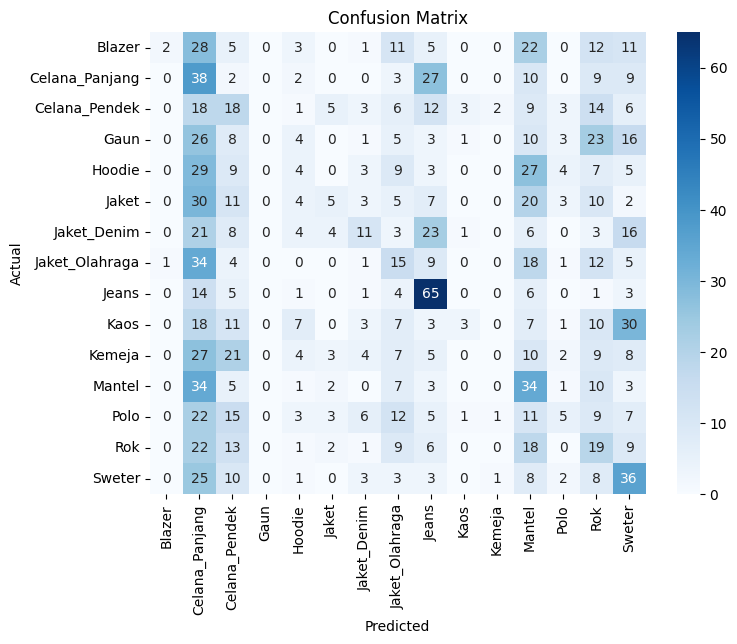

Time taken for epoch: 114.27 sec

Epoch [2/10], Train Loss: 2.3412, Train Accuracy: 0.2340, Train F1: 0.2262, Train Precision: 0.2239, Train Recall: 0.2340
Test Accuracy: 0.2813, Test F1: 0.2694, Test Precision: 0.3396, Test Recall: 0.2813


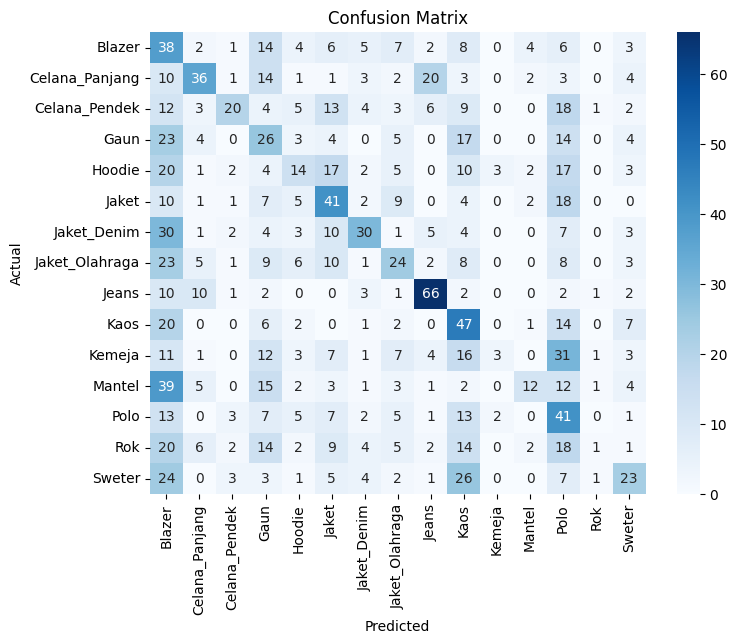

Time taken for epoch: 114.42 sec

Epoch [3/10], Train Loss: 2.0857, Train Accuracy: 0.3307, Train F1: 0.3242, Train Precision: 0.3237, Train Recall: 0.3307
Test Accuracy: 0.3507, Test F1: 0.3436, Test Precision: 0.3771, Test Recall: 0.3507


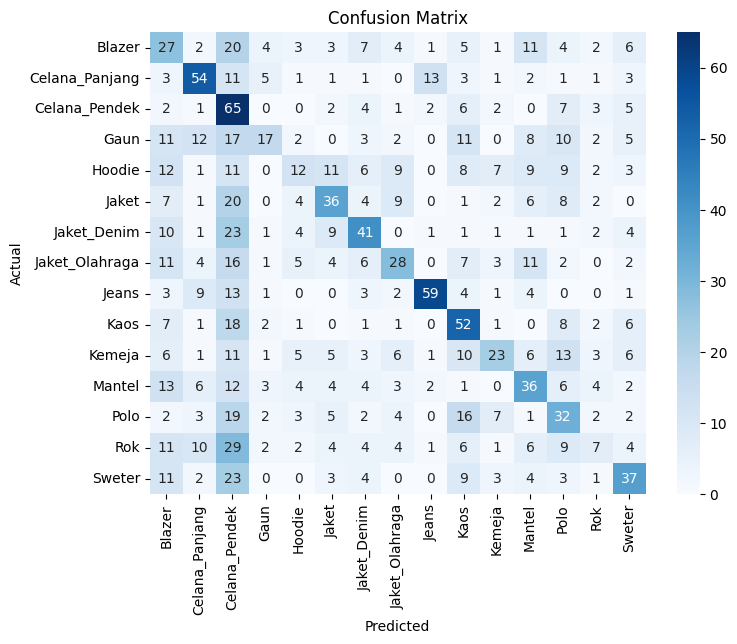

Time taken for epoch: 116.06 sec

Epoch [4/10], Train Loss: 1.8391, Train Accuracy: 0.4013, Train F1: 0.3960, Train Precision: 0.3968, Train Recall: 0.4013
Test Accuracy: 0.3740, Test F1: 0.3743, Test Precision: 0.3978, Test Recall: 0.3740


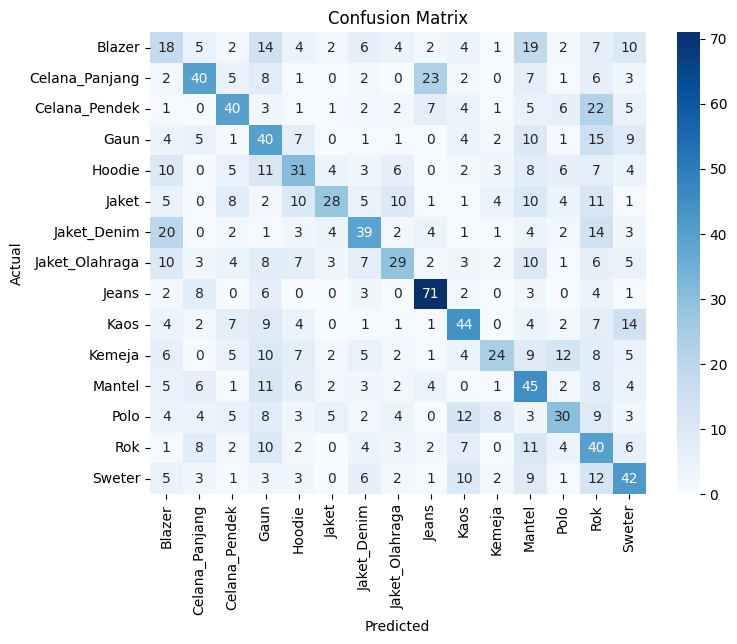

Time taken for epoch: 112.19 sec

Epoch [5/10], Train Loss: 1.6603, Train Accuracy: 0.4595, Train F1: 0.4558, Train Precision: 0.4562, Train Recall: 0.4595
Test Accuracy: 0.3907, Test F1: 0.3805, Test Precision: 0.4597, Test Recall: 0.3907


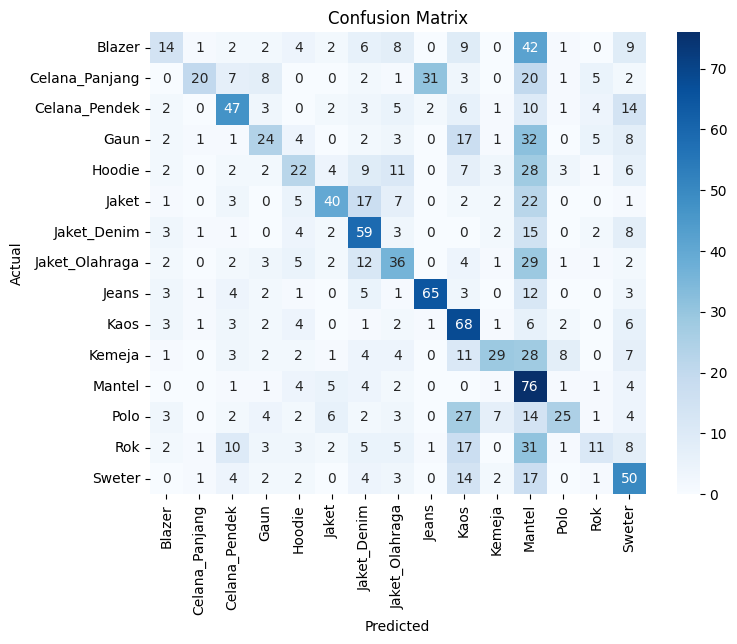

Time taken for epoch: 114.92 sec

Epoch [6/10], Train Loss: 1.4785, Train Accuracy: 0.5118, Train F1: 0.5077, Train Precision: 0.5076, Train Recall: 0.5118
Test Accuracy: 0.4300, Test F1: 0.4293, Test Precision: 0.4752, Test Recall: 0.4300


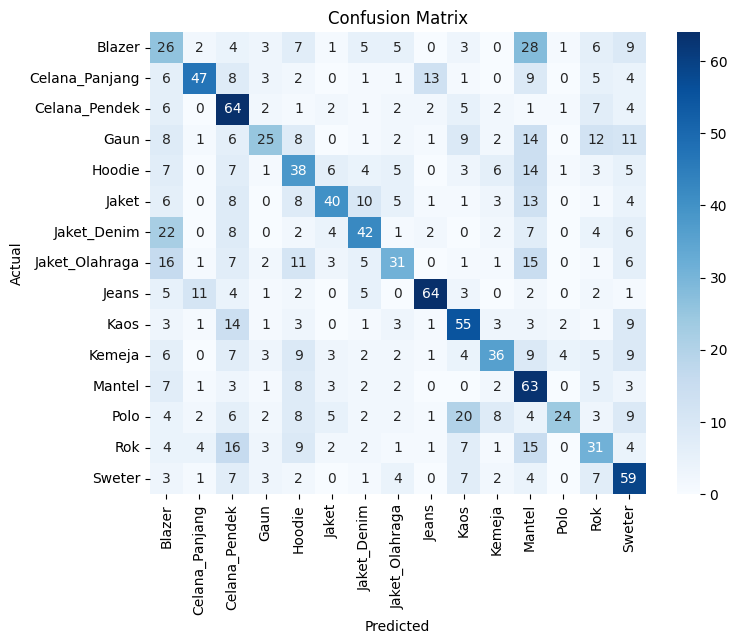

Time taken for epoch: 114.74 sec

Epoch [7/10], Train Loss: 1.2890, Train Accuracy: 0.5712, Train F1: 0.5684, Train Precision: 0.5685, Train Recall: 0.5712
Test Accuracy: 0.4307, Test F1: 0.4213, Test Precision: 0.4574, Test Recall: 0.4307


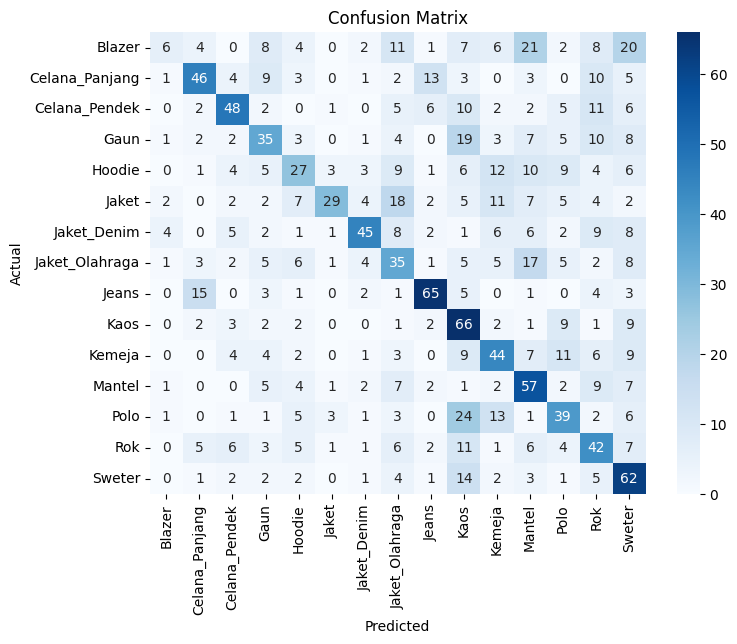

Time taken for epoch: 115.01 sec

Epoch [8/10], Train Loss: 1.0817, Train Accuracy: 0.6407, Train F1: 0.6384, Train Precision: 0.6384, Train Recall: 0.6407
Test Accuracy: 0.4387, Test F1: 0.4359, Test Precision: 0.4409, Test Recall: 0.4387


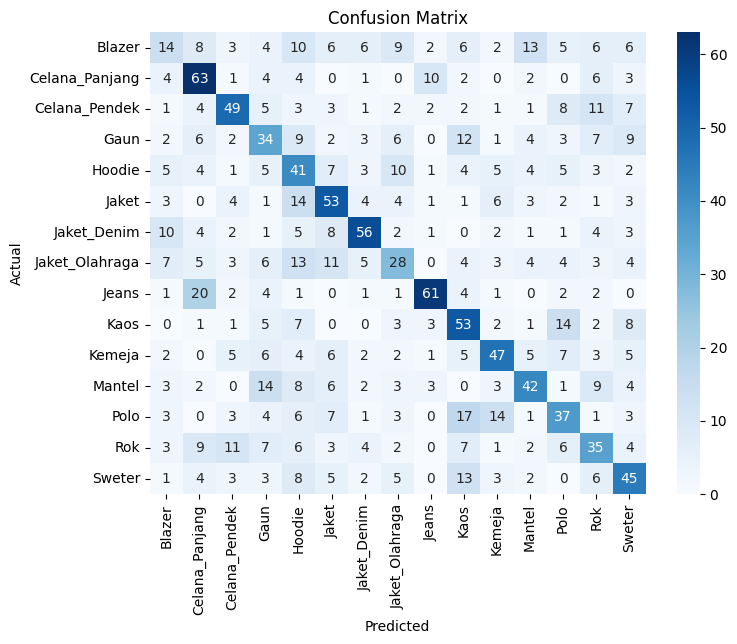

Time taken for epoch: 114.58 sec

Epoch [9/10], Train Loss: 0.9180, Train Accuracy: 0.6957, Train F1: 0.6945, Train Precision: 0.6945, Train Recall: 0.6957
Test Accuracy: 0.4400, Test F1: 0.4306, Test Precision: 0.4709, Test Recall: 0.4400


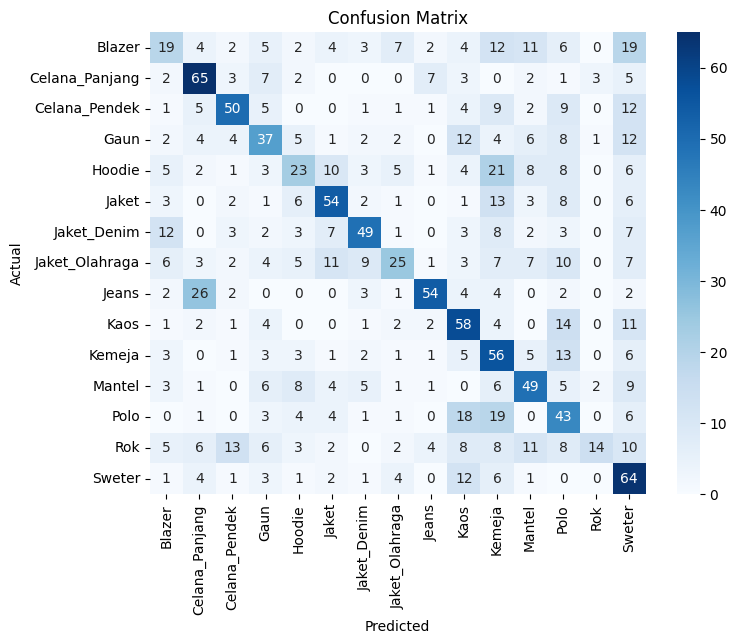

Time taken for epoch: 115.20 sec

Epoch [10/10], Train Loss: 0.6949, Train Accuracy: 0.7693, Train F1: 0.7686, Train Precision: 0.7686, Train Recall: 0.7693
Test Accuracy: 0.4360, Test F1: 0.4324, Test Precision: 0.4524, Test Recall: 0.4360


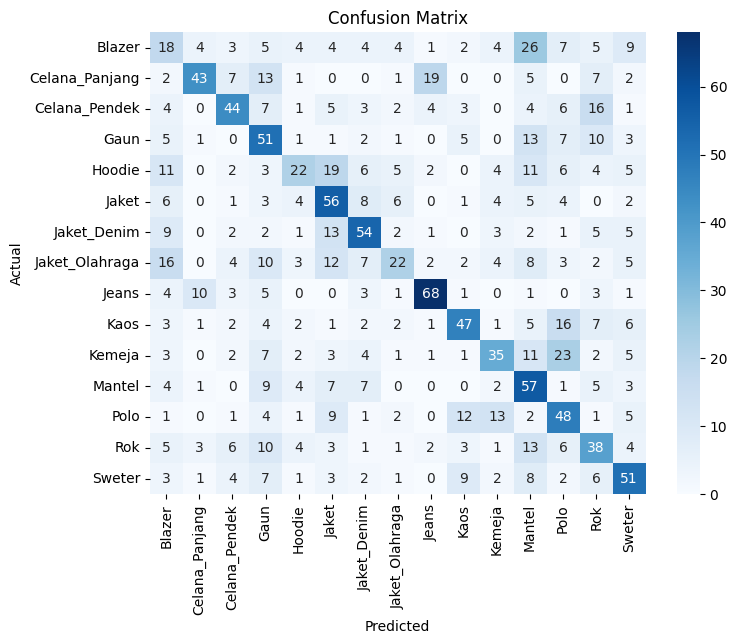

Time taken for epoch: 112.72 sec



In [ ]:
lib_6.train_model(custom_transfer_model, train_loader, test_loader, custom_transfer_criterion, custom_transfer_optimizer, custom_transfer_scheduler, test_dataset, num_epochs=10)

Проведем **анализ обучения** кастомной трансформерной модели.

**Обучение (Train):**
* Точность (Accuracy): выросла с ~13% до ~77%, что говорит о хорошей способности модели запоминать обучающую выборку.
* F1-score: достиг ~0.77, согласуется с остальными метриками.
* Потери (Loss): плавно снижались от 2.66 до 0.69, что указывает на стабильное обучение.
* Модель обучается эффективно и уверенно захватывает паттерны в обучающих данных.

**Тестирование (Test):**
* Точность (Accuracy): поднялась с ~17% до ~43.6% — умеренное улучшение, но не соответствует уровню на тренировке.
* F1-score: вырос до ~0.43, что указывает на среднюю способность к обобщению.
* Precision / Recall: тоже выросли, но сохраняют разбаланс.
* Признаки переобучения к концу: модель хорошо запомнила данные, но слабо обобщает.

**Матрица ошибок:**
* Ошибки распределены по всей матрице, нет явно "доминирующих" классов.
* Часто путает между близкими по признакам метками.
* Классы с малым количеством примеров явно проседают.

**Выводы:**
* Обучаемость	- высокая (стабильный рост метрик на train)
* Обобщающая способность - средняя (тестовые метрики ниже обучающих)
* Баланс Precision/Recall	- умеренный, немного в сторону precision
* Overfitting	- присутствует (разрыв между train/test)
* Время на эпоху - ~114 секунд (приемлемо для трансформера)
* Итог - модель базово работает, но требует доработки — архитектурно или через регуляризацию/бейзлайн

Проведем **улучшение бейзлайна**. Гипотезы для улучшения бейзлайна моделей VGG16, ViT, кастомной сверточной модели и кастомной трансформерной модели основаны на анализе метрик, результатов обучения, тестирования и confusion matrix. Цель этих улучшений – повысить обобщающую способность моделей, снизить переобучение и улучшить точность классификации сложных классов.

1. Аугментация данных. Недостаточная вариативность данных может приводить к переобучению VGG16 и затрудненной классификации некоторых классов у ViT. Для улучшения можно использовать горизонтальное/вертикальное отражение, случайные повороты, масштабирование, изменение яркости и контраста, обрезки и шум (например, гауссов шум).

2. Настройка гиперпараметров. Снизить learning rate и использовать динамическое уменьшение (ReduceLROnPlateau). Ввести раннее прекращение (Early Stopping), чтобы избежать переобучения, если валидационные метрики перестают улучшаться. Применить более продвинутые оптимизаторы, такие как AdamW.

3. Fine-tuning моделей. Для ViT заморозить начальные слои и обучать только последние. Это может улучшить результаты на специфичных данных. Для VGG16 дообучить последние слои и применить Dropout для регуляризации.

Эти гипотезы направлены на улучшение производительности моделей за счет аугментации, настройки гиперпараметров, использования методов регуляризации. Внедрение предложенных методов должно повысить точность и устойчивость моделей на тестовой выборке.

Задаём размер батча 32. Для обучающего набора применяем аугментацию: случайные повороты, отражения, изменение яркости, контраста и масштабирования, чтобы улучшить обобщающую способность модели. Для тестового набора применяем только базовые преобразования: изменение размера, обрезка по центру и нормализация. Загружаем изображения из папок и создаём загрузчики данных для обучения и тестирования.

In [ ]:
batch_size = 32

# Аугментация тренировочных данных
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),         # Случайное горизонтальное отражение
    transforms.RandomVerticalFlip(),           # Случайное вертикальное отражение
    transforms.RandomRotation(20),             # Случайный поворот на ±20 градусов
    transforms.RandomResizedCrop(224),         # Случайное обрезание и изменение масштаба
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Изменение яркости и контраста
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),  # Гауссов шум
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

# Применение только базовых преобразований для тестового набора
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

improved_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
improved_test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

improved_train_loader = DataLoader(improved_train_dataset, batch_size=batch_size, shuffle=True)
improved_test_loader = DataLoader(improved_test_dataset, batch_size=batch_size, shuffle=False)

Загружаем предобученную модель VGG16. Замораживаем сверточную часть, чтобы обучать только классификатор. Заменяем классификатор на новый с двумя слоями Dropout и выходом под нужное количество классов. Переносим модель на устройство, задаём функцию потерь, оптимизатор AdamW и scheduler для уменьшения learning rate каждые 5 эпох.

In [ ]:
improved_vgg16_model = models.vgg16(pretrained=True)

for param in improved_vgg16_model.features.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)
improved_vgg16_model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)

improved_vgg16_model = improved_vgg16_model.to(device)

improved_vgg16_criterion = nn.CrossEntropyLoss()
improved_vgg16_optimizer = optim.AdamW(improved_vgg16_model.parameters(), lr=0.0005)
improved_vgg16_scheduler = optim.lr_scheduler.StepLR(improved_vgg16_optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Запускаем обучение сверточной модели VGG16 после улучшения бейзлайна.

Epoch [1/10], Train Loss: 1.3891, Train Accuracy: 0.5488, Train F1: 0.5472, Train Precision: 0.5487, Train Recall: 0.5488
Test Accuracy: 0.7460, Test F1: 0.7410, Test Precision: 0.7573, Test Recall: 0.7460


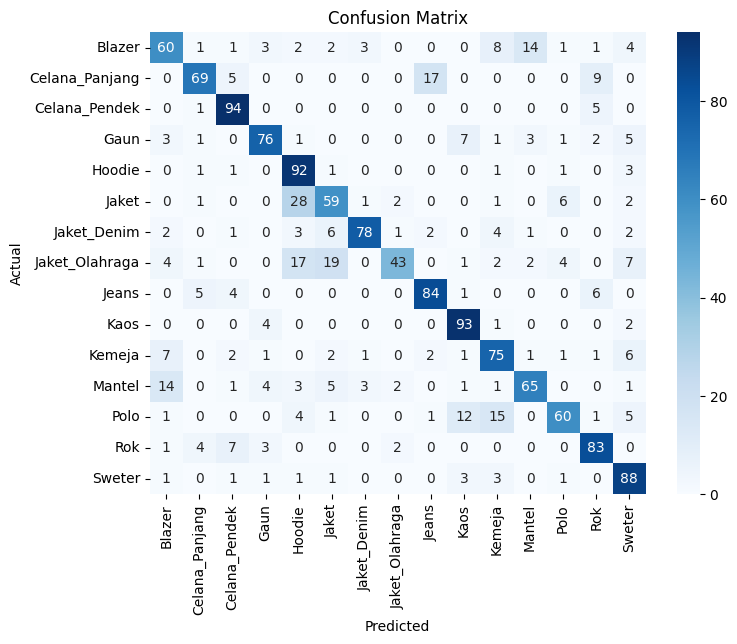

Time taken for epoch: 166.18 sec

Epoch [2/10], Train Loss: 0.6235, Train Accuracy: 0.7947, Train F1: 0.7940, Train Precision: 0.7942, Train Recall: 0.7947
Test Accuracy: 0.7880, Test F1: 0.7911, Test Precision: 0.8091, Test Recall: 0.7880


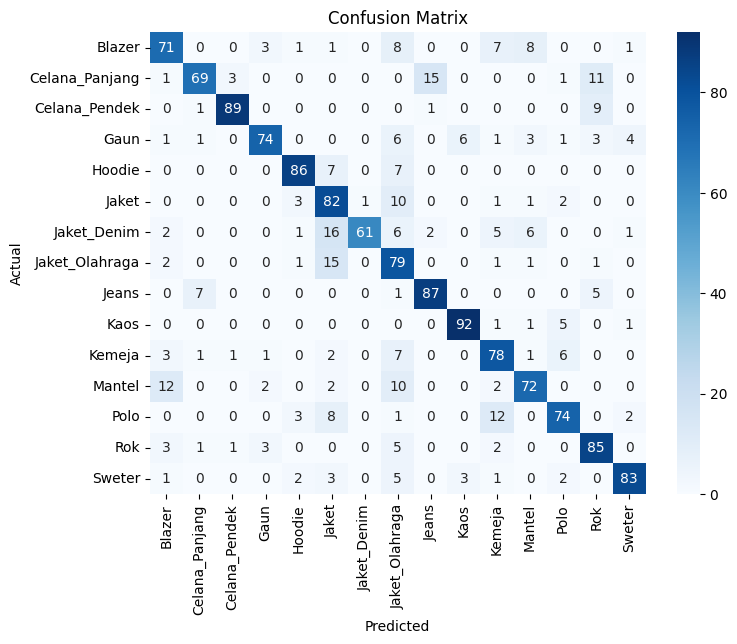

Time taken for epoch: 146.50 sec

Epoch [3/10], Train Loss: 0.3556, Train Accuracy: 0.8842, Train F1: 0.8840, Train Precision: 0.8840, Train Recall: 0.8842
Test Accuracy: 0.7987, Test F1: 0.8006, Test Precision: 0.8171, Test Recall: 0.7987


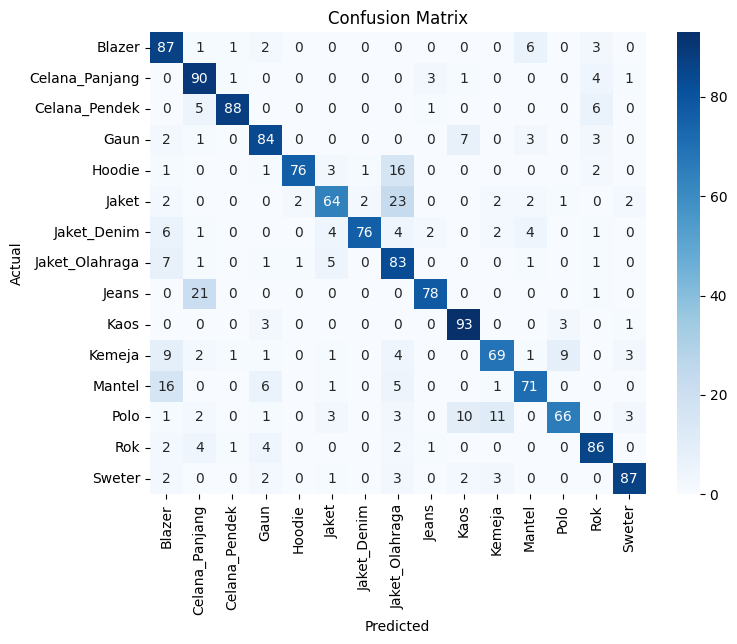

Time taken for epoch: 136.68 sec

Epoch [4/10], Train Loss: 0.2099, Train Accuracy: 0.9290, Train F1: 0.9289, Train Precision: 0.9290, Train Recall: 0.9290
Test Accuracy: 0.7893, Test F1: 0.7859, Test Precision: 0.7954, Test Recall: 0.7893


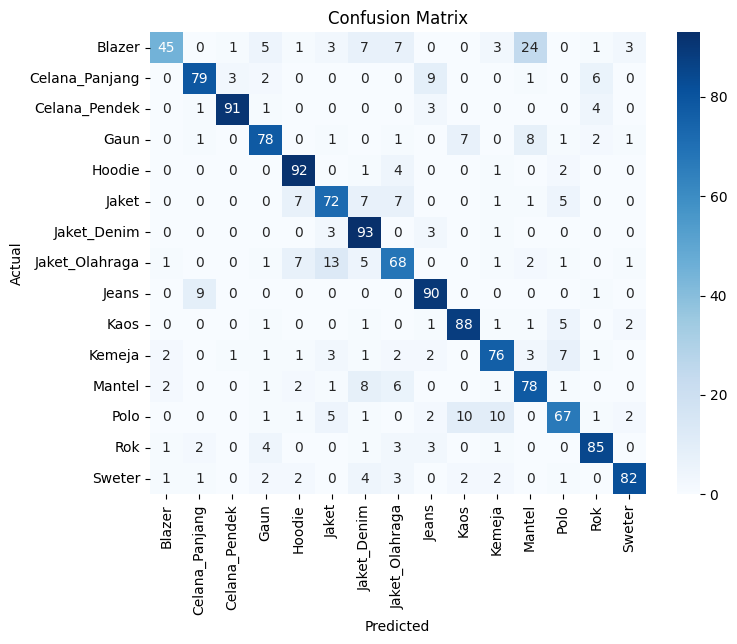

Time taken for epoch: 159.80 sec

Epoch [5/10], Train Loss: 0.1757, Train Accuracy: 0.9450, Train F1: 0.9449, Train Precision: 0.9449, Train Recall: 0.9450
Test Accuracy: 0.7967, Test F1: 0.7922, Test Precision: 0.8107, Test Recall: 0.7967


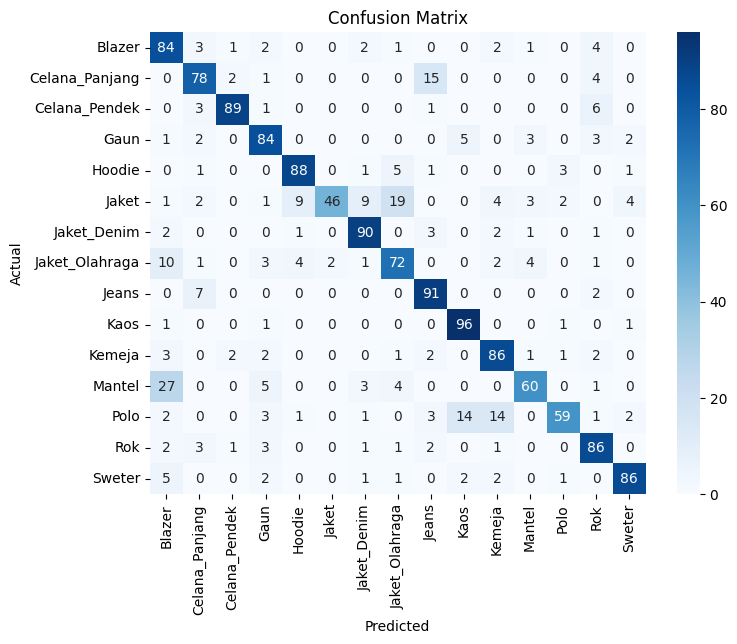

Time taken for epoch: 136.35 sec

Epoch [6/10], Train Loss: 0.0523, Train Accuracy: 0.9817, Train F1: 0.9816, Train Precision: 0.9818, Train Recall: 0.9817
Test Accuracy: 0.8347, Test F1: 0.8353, Test Precision: 0.8376, Test Recall: 0.8347


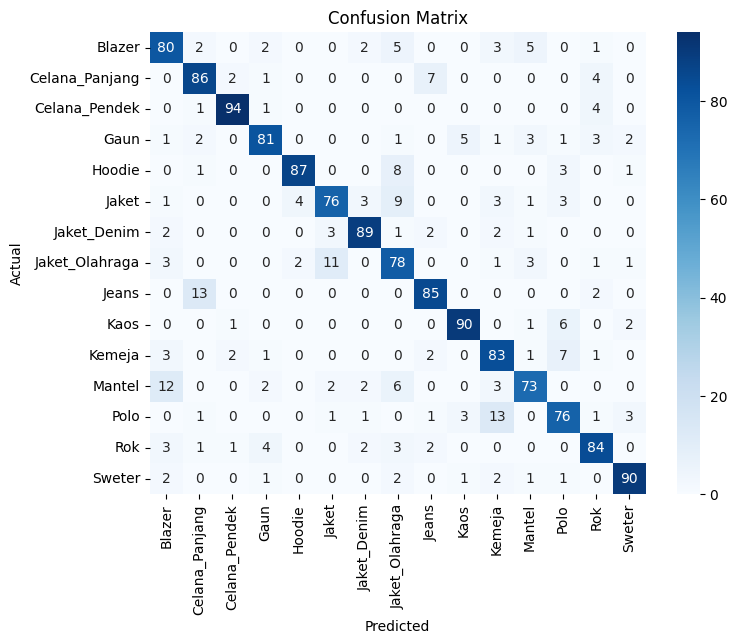

Time taken for epoch: 137.79 sec

Epoch [7/10], Train Loss: 0.0262, Train Accuracy: 0.9900, Train F1: 0.9900, Train Precision: 0.9901, Train Recall: 0.9900
Test Accuracy: 0.8293, Test F1: 0.8296, Test Precision: 0.8305, Test Recall: 0.8293


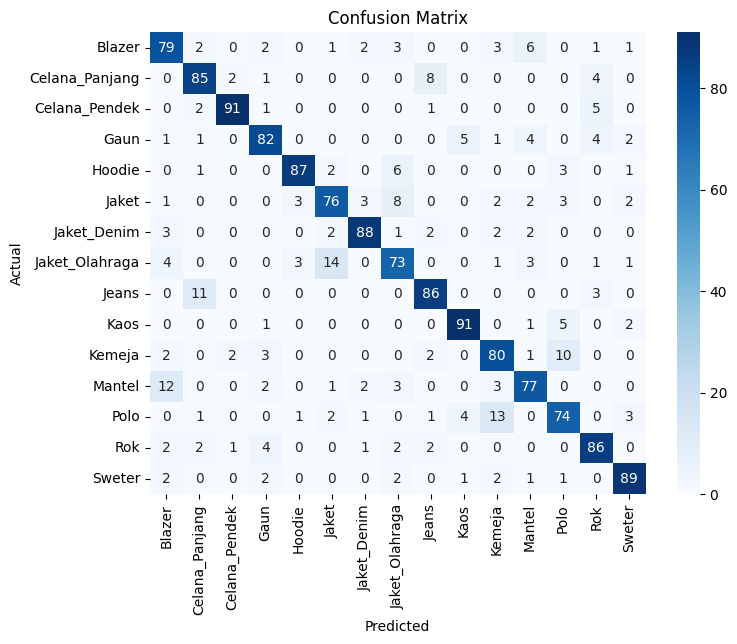

Time taken for epoch: 135.37 sec

Epoch [8/10], Train Loss: 0.0220, Train Accuracy: 0.9897, Train F1: 0.9897, Train Precision: 0.9897, Train Recall: 0.9897
Test Accuracy: 0.8280, Test F1: 0.8284, Test Precision: 0.8298, Test Recall: 0.8280


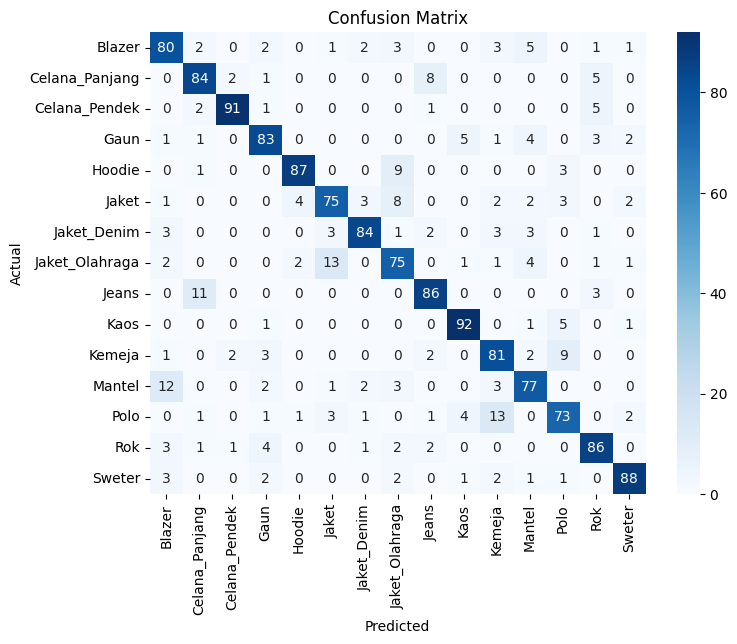

Time taken for epoch: 135.68 sec

Epoch [9/10], Train Loss: 0.0207, Train Accuracy: 0.9915, Train F1: 0.9915, Train Precision: 0.9915, Train Recall: 0.9915
Test Accuracy: 0.8293, Test F1: 0.8298, Test Precision: 0.8317, Test Recall: 0.8293


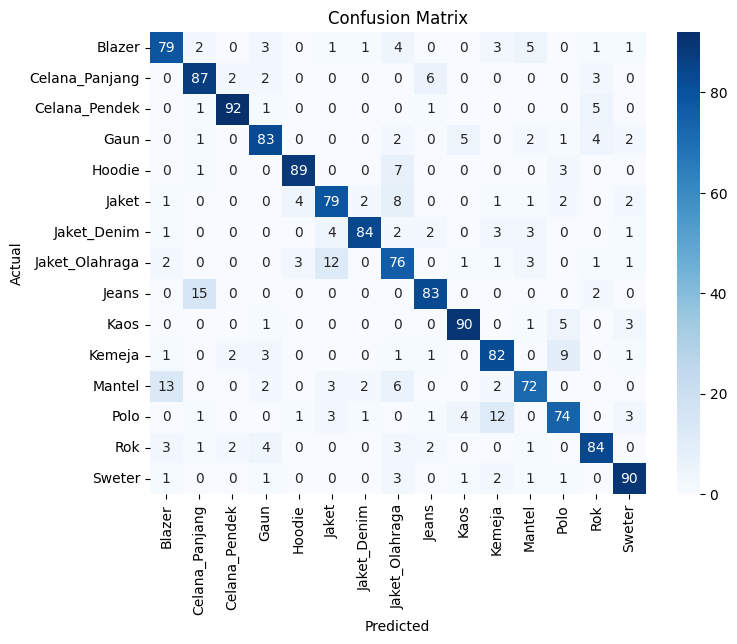

Time taken for epoch: 136.12 sec

Epoch [10/10], Train Loss: 0.0172, Train Accuracy: 0.9925, Train F1: 0.9925, Train Precision: 0.9925, Train Recall: 0.9925
Test Accuracy: 0.8293, Test F1: 0.8297, Test Precision: 0.8308, Test Recall: 0.8293


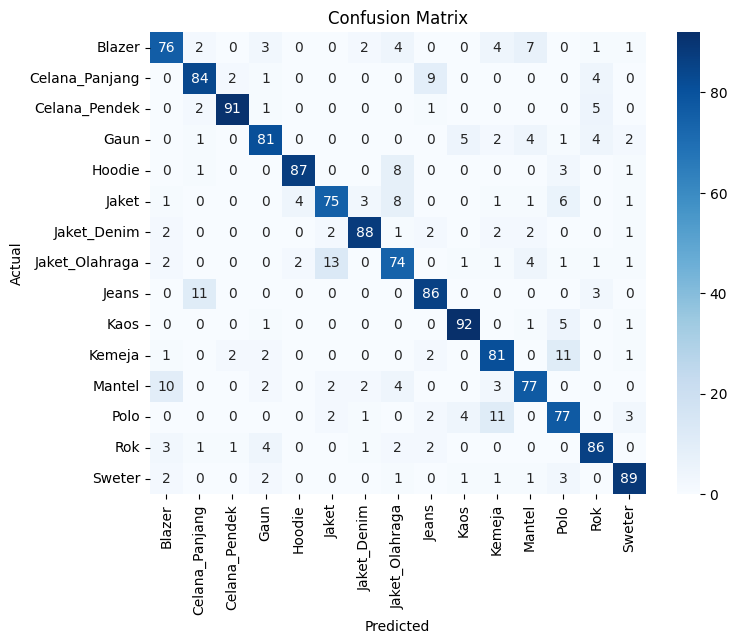

Time taken for epoch: 138.74 sec



In [ ]:
lib_6.train_model(improved_vgg16_model, improved_train_loader, improved_test_loader, improved_vgg16_criterion, improved_vgg16_optimizer, improved_vgg16_scheduler, improved_test_dataset, num_epochs=10)

Проведем **анализ результатов обучения и сравнение с результатами до улучшения бейзлайна.**

In [ ]:
data = {
    'Метрика': ['До (финал)', 'После (финал)', 'Улучшение'],
    'Train Accuracy': [0.9387, 0.9925, '+5.4%'],
    'Test Accuracy': [0.6833, 0.8293, '+14.6%'],
    'Test F1': [0.6827, 0.8297, '+14.7%'],
    'Test Precision': [0.688, 0.8308, '+14.2%'],
    'Test Recall': [0.6833, 0.8293, '+14.6%']
}

table = pd.DataFrame(data)
table

То есть, **качество обобщения на тестовой выборке значительно выросло**. Особенно важен **рост F1-score**, т.к. он учитывает и precision, и recall — значит, модель не просто чаще угадывает, но делает это сбалансированно.

**Train Loss:**
* Резко снизился уже с первой эпохи: 2.5459 → 1.3891
* Финальное значение: 0.1908 → 0.0172, что указывает на намного более уверенное обучение модели.

**Начальная точность (Epoch 1):**
* Было: Train Acc = 0.1592, Test Acc = 0.2360
* Стало: Train Acc = 0.5488, Test Acc = 0.7460
* Это огромный прыжок!

**Переобучение?**
* Пока не критично:
  * Train Acc вырос до 0.99+, но Test Acc остаётся стабильным на уровне ~0.83
  * Gap между Train и Test есть, но не настолько сильный, как раньше

**Confusion Matrix:**
* Классы в целом хорошо различаются
* Некоторые ошибки остаются между близкими классами (например, 11 путается с 0 и 12, 7 с 5)
* Ошибок меньше, чем раньше — особенно по диагонали много значений > 85

**Итог:**
* Обучение стало быстрее и эффективнее.
* Модель уверенно классифицирует с высокой точностью.
* Ошибки сведены к минимуму, метрики на тесте значительно выше.
* Финальные показатели говорят о том, что модель действительно обобщает, а не только запоминает.

Загружаем предобученную модель ViT и замораживаем все её слои. Заменяем выходной слой на новый с числом классов задачи и разрешаем обучение только для него. Переносим модель на устройство, задаём функцию потерь, оптимизатор AdamW для обучаемых параметров и scheduler для снижения learning rate каждые 5 эпох.

In [ ]:
improved_vit_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

for param in improved_vit_model.parameters():
    param.requires_grad = False

for block in improved_vit_model.encoder.layers[-2:]:
    for param in block.parameters():
        param.requires_grad = True

improved_vit_model.heads[-1] = nn.Linear(improved_vit_model.heads[-1].in_features, len(train_dataset.classes))
for param in improved_vit_model.heads[-1].parameters():
    param.requires_grad = True

improved_vit_model = improved_vit_model.to(device)

improved_vit_criterion = nn.CrossEntropyLoss()
improved_vit_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, improved_vit_model.parameters()), lr=0.0005, weight_decay=1e-4)
improved_vit_scheduler = optim.lr_scheduler.StepLR(improved_vit_optimizer, step_size=5, gamma=0.1)

Запускаем обучение трансформерной модели ViT-B/16 после улучшения бейзлайна.

Epoch [1/10], Train Loss: 0.9952, Train Accuracy: 0.6798, Train F1: 0.6784, Train Precision: 0.6790, Train Recall: 0.6798
Test Accuracy: 0.7827, Test F1: 0.7776, Test Precision: 0.8069, Test Recall: 0.7827


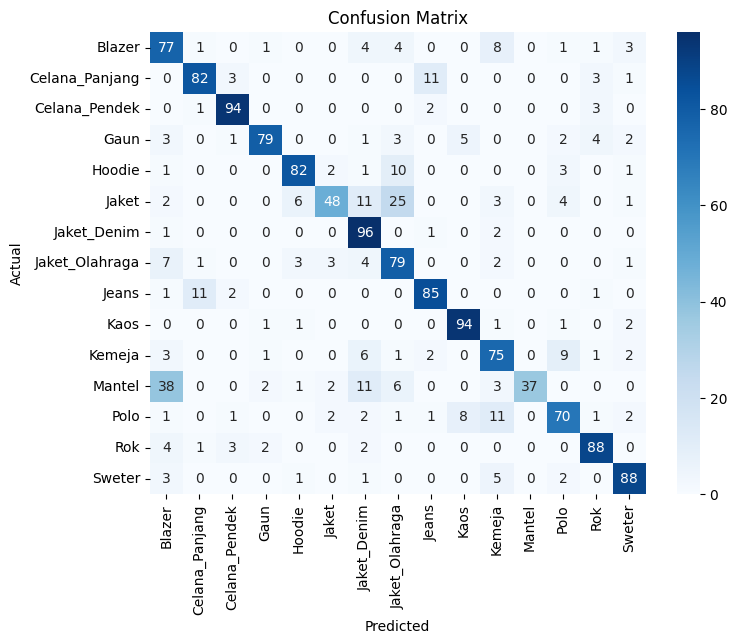

Time taken for epoch: 225.58 sec

Epoch [2/10], Train Loss: 0.4048, Train Accuracy: 0.8700, Train F1: 0.8694, Train Precision: 0.8693, Train Recall: 0.8700
Test Accuracy: 0.7680, Test F1: 0.7658, Test Precision: 0.8017, Test Recall: 0.7680


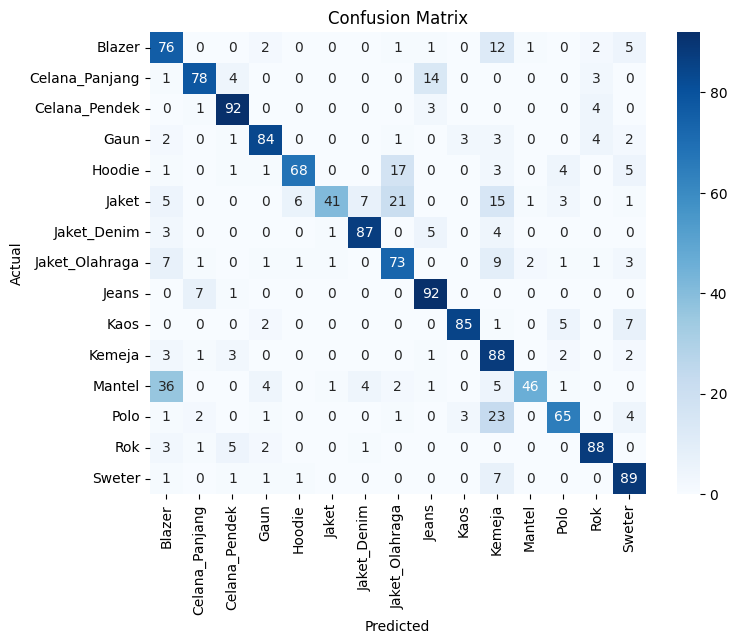

Time taken for epoch: 229.66 sec

Epoch [3/10], Train Loss: 0.2346, Train Accuracy: 0.9232, Train F1: 0.9230, Train Precision: 0.9229, Train Recall: 0.9232
Test Accuracy: 0.7753, Test F1: 0.7765, Test Precision: 0.8155, Test Recall: 0.7753


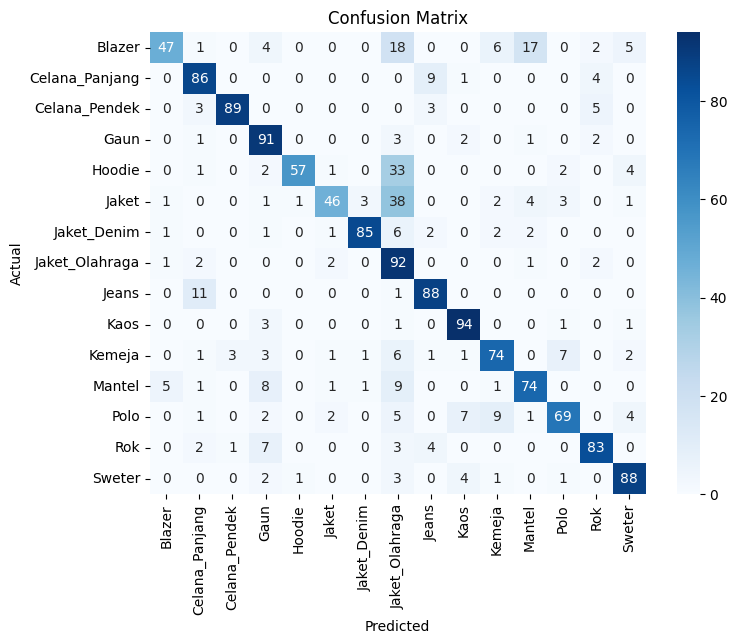

Time taken for epoch: 230.69 sec

Epoch [4/10], Train Loss: 0.1547, Train Accuracy: 0.9512, Train F1: 0.9511, Train Precision: 0.9513, Train Recall: 0.9512
Test Accuracy: 0.7820, Test F1: 0.7833, Test Precision: 0.7971, Test Recall: 0.7820


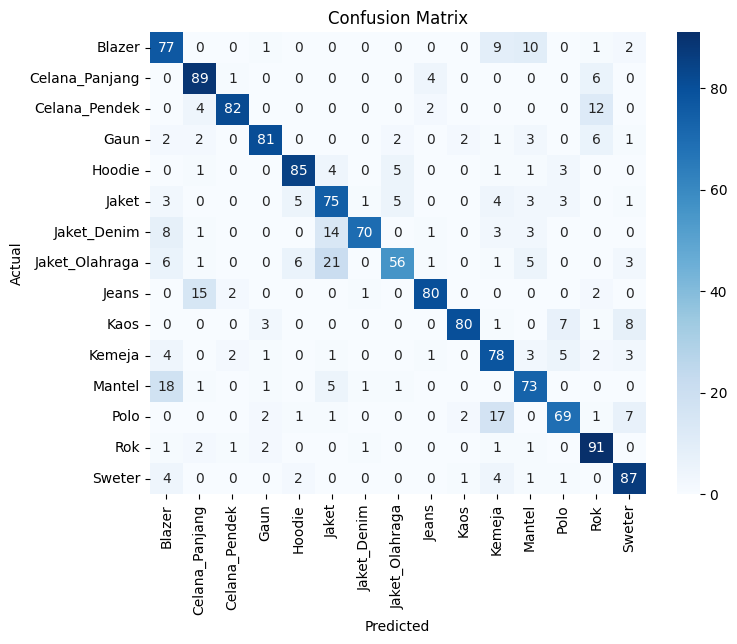

Time taken for epoch: 230.53 sec

Epoch [5/10], Train Loss: 0.1667, Train Accuracy: 0.9450, Train F1: 0.9449, Train Precision: 0.9450, Train Recall: 0.9450
Test Accuracy: 0.7807, Test F1: 0.7794, Test Precision: 0.7921, Test Recall: 0.7807


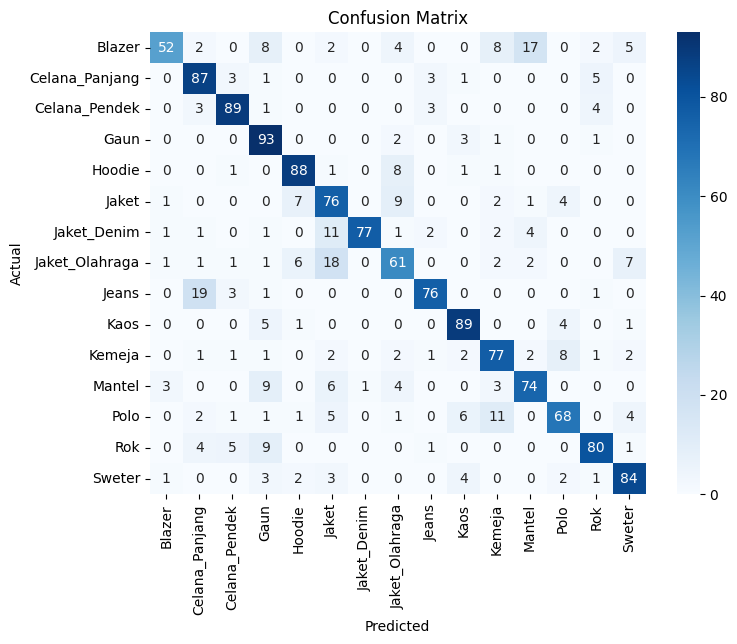

Time taken for epoch: 229.86 sec

Epoch [6/10], Train Loss: 0.0455, Train Accuracy: 0.9853, Train F1: 0.9853, Train Precision: 0.9854, Train Recall: 0.9853
Test Accuracy: 0.8160, Test F1: 0.8167, Test Precision: 0.8193, Test Recall: 0.8160


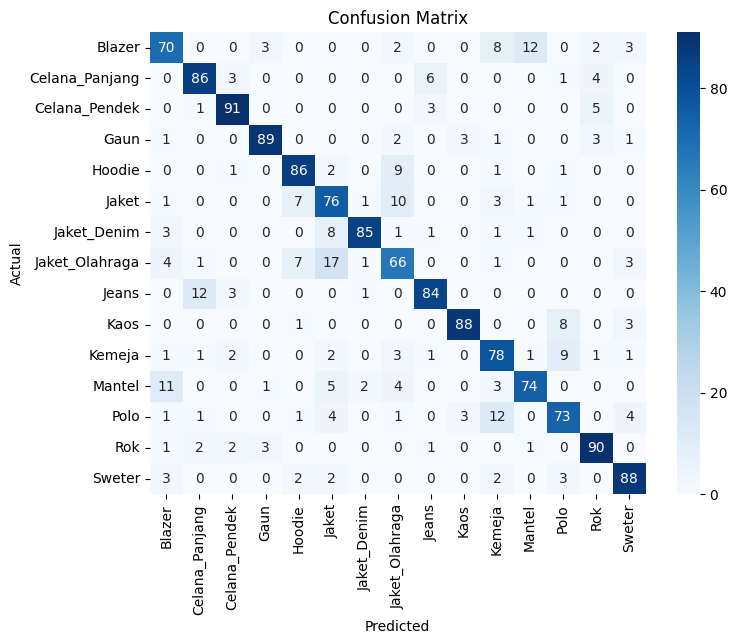

Time taken for epoch: 230.18 sec

Epoch [7/10], Train Loss: 0.0244, Train Accuracy: 0.9920, Train F1: 0.9920, Train Precision: 0.9920, Train Recall: 0.9920
Test Accuracy: 0.8220, Test F1: 0.8223, Test Precision: 0.8254, Test Recall: 0.8220


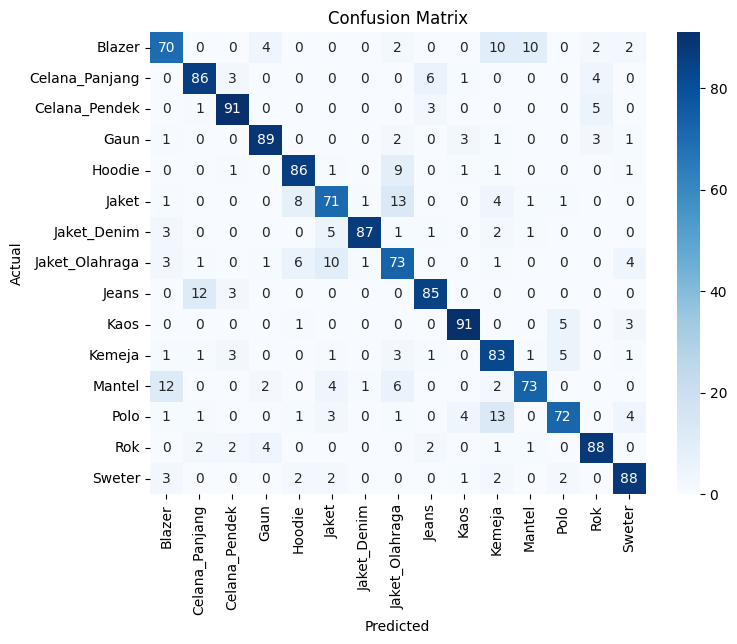

Time taken for epoch: 230.69 sec

Epoch [8/10], Train Loss: 0.0207, Train Accuracy: 0.9918, Train F1: 0.9918, Train Precision: 0.9918, Train Recall: 0.9918
Test Accuracy: 0.8207, Test F1: 0.8207, Test Precision: 0.8225, Test Recall: 0.8207


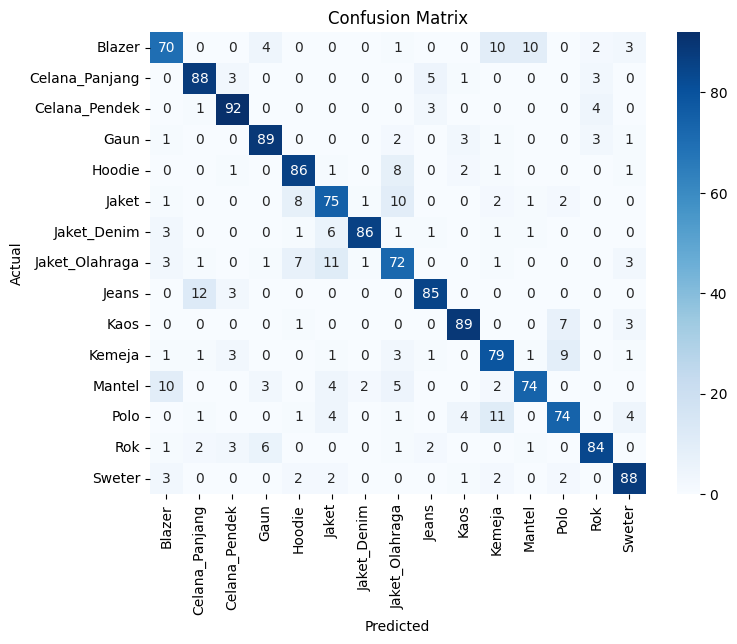

Time taken for epoch: 230.66 sec

Epoch [9/10], Train Loss: 0.0189, Train Accuracy: 0.9905, Train F1: 0.9905, Train Precision: 0.9905, Train Recall: 0.9905
Test Accuracy: 0.8240, Test F1: 0.8242, Test Precision: 0.8261, Test Recall: 0.8240


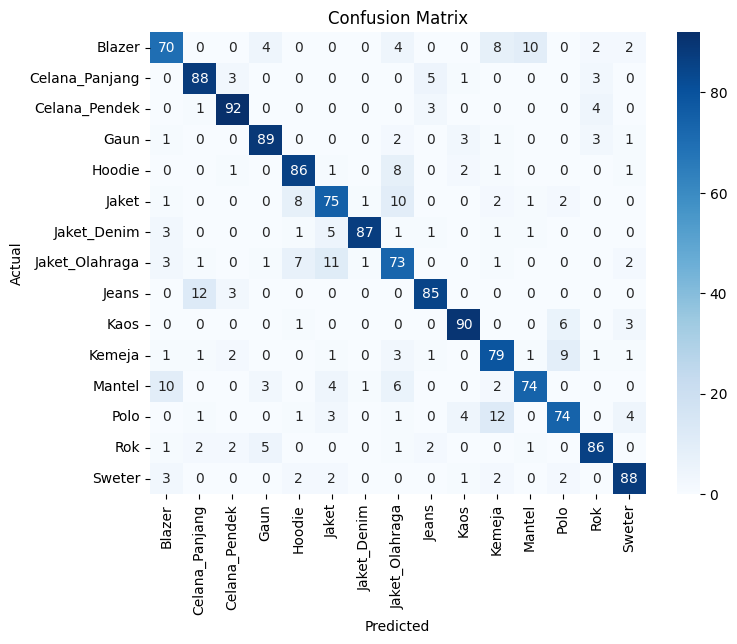

Time taken for epoch: 230.52 sec

Epoch [10/10], Train Loss: 0.0177, Train Accuracy: 0.9907, Train F1: 0.9907, Train Precision: 0.9907, Train Recall: 0.9907
Test Accuracy: 0.8233, Test F1: 0.8234, Test Precision: 0.8267, Test Recall: 0.8233


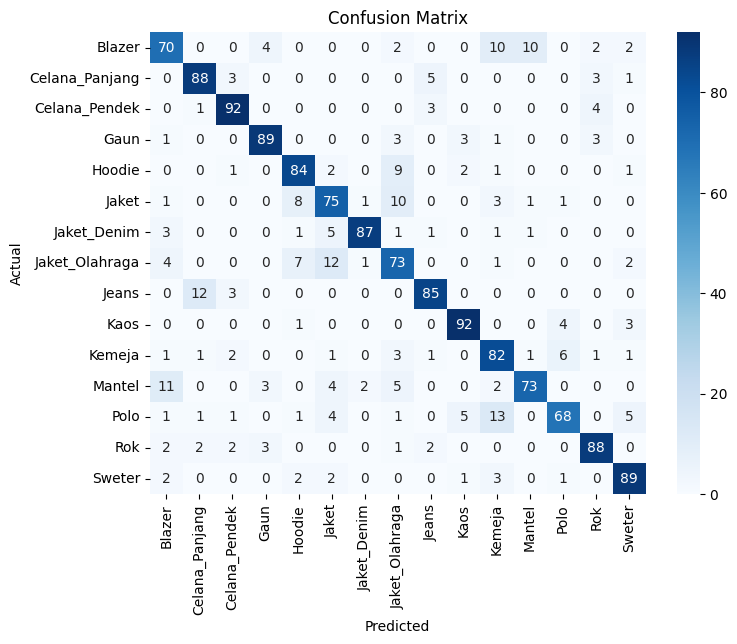

Time taken for epoch: 230.04 sec



In [ ]:
lib_6.train_model(improved_vit_model, improved_train_loader, improved_test_loader, improved_vit_criterion, improved_vit_optimizer, improved_vit_scheduler, improved_test_dataset, num_epochs=10)

Проведем **анализ результатов обучения** и **сравнение с результатами до улучшения бейзлайна**.

После улучшения бейзлайна результаты ViT-B/16 радикально улучшились.

**Метрики:**
* Уже на 1-й эпохе Train Accuracy: ~68% против ~8% раньше
* К 3-й эпохе — модель уже переходит 92% точности на обучении
* Test Accuracy стабилизируется в районе 82% — это говорит о хорошем обобщении

**Потери (Loss):**
* Train Loss: с 2.19 → 0.0177 (!)
* Убывает экспоненциально, что говорит об успешном градиентном спуске

**Confusion Matrix:**
* Чётко доминирует диагональ — модель правильно классифицирует большинство объектов
* Ошибки локализованы в отдельных парах классов (например, 5↔7, 6↔5, 11↔0 и пр.)
* В некоторых классах — почти нулевые ошибки (напр. класс 9, 10, 2)
* В общем — очень здоровая матрица, характерная для хорошо обученной модели.

**Вывод:**
* Модель начала обучаться в разы лучше, с почти в 3.5 раза большей точностью на тесте, и в 4+ раза более высоким F1-score.
* Это огромный успех по сравнению с бейзлайном.

Инициализируем улучшенную кастомную сверточную модель с 15 классами и переносим её на устройство. Задаём функцию потерь CrossEntropyLoss, оптимизатор AdamW и scheduler ReduceLROnPlateau, который снижает learning rate при отсутствии улучшения метрики.

In [ ]:
improved_cnn_model = ImprovedCNN(num_classes=15).to(device)

improved_cnn_criterion = nn.CrossEntropyLoss()
improved_cnn_optimizer = optim.AdamW(improved_cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
improved_cnn_scheduler = ReduceLROnPlateau(improved_cnn_optimizer, mode='max', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Запускаем обучение улучшенной кастомной сверточной модели.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/20], Train Loss: 2.7096, Train Accuracy: 0.1198, Train F1: 0.1167, Precision: 0.1181, Recall: 0.1198
Test Loss: 2.8258, Test Accuracy: 0.1807, Test F1: 0.1341, Precision: 0.1614, Recall: 0.1807
Time taken: 170.33 sec



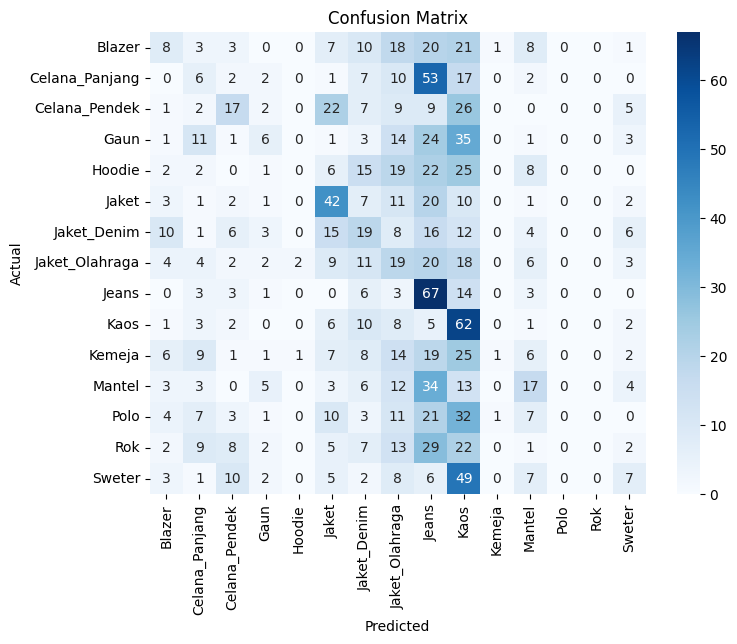

Epoch [2/20], Train Loss: 2.2417, Train Accuracy: 0.2645, Train F1: 0.2586, Precision: 0.2569, Recall: 0.2645
Test Loss: 1.9671, Test Accuracy: 0.3627, Test F1: 0.3523, Precision: 0.4103, Recall: 0.3627
Time taken: 174.84 sec



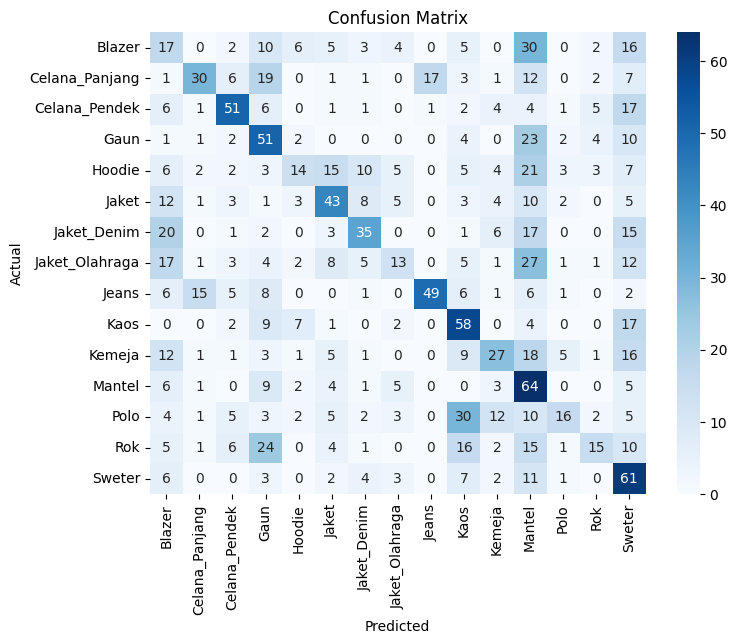

Epoch [3/20], Train Loss: 1.8064, Train Accuracy: 0.4180, Train F1: 0.4093, Precision: 0.4082, Recall: 0.4180
Test Loss: 1.5737, Test Accuracy: 0.4960, Test F1: 0.4891, Precision: 0.5049, Recall: 0.4960
Time taken: 177.54 sec



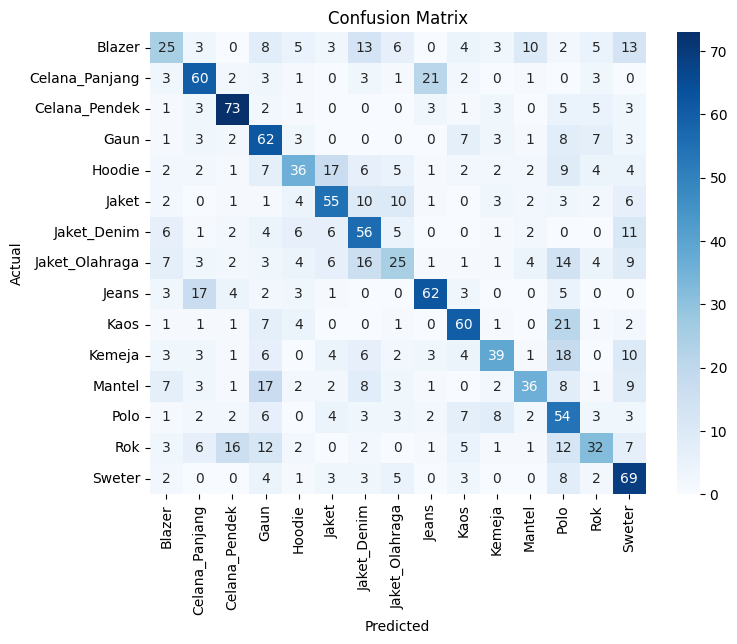

Epoch [4/20], Train Loss: 1.4984, Train Accuracy: 0.5160, Train F1: 0.5118, Precision: 0.5118, Recall: 0.5160
Test Loss: 1.4217, Test Accuracy: 0.5527, Test F1: 0.5441, Precision: 0.5704, Recall: 0.5527
Time taken: 177.52 sec



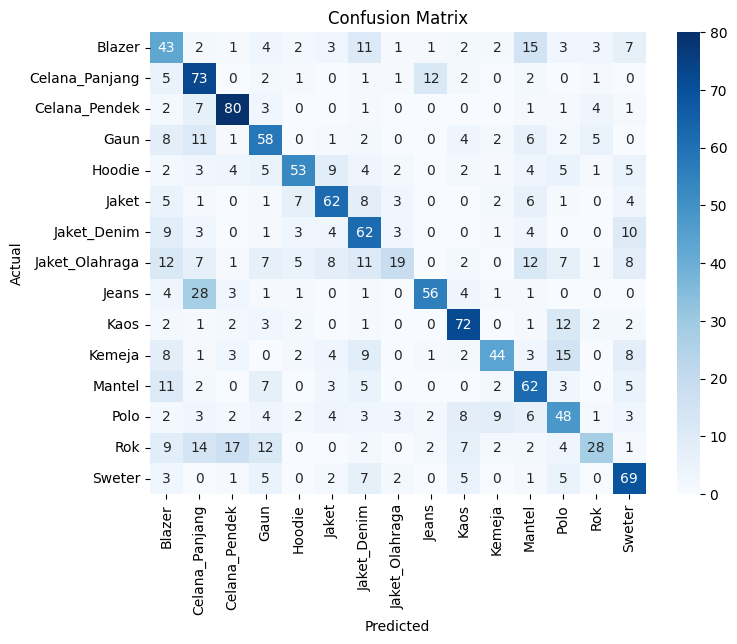

Epoch [5/20], Train Loss: 1.2813, Train Accuracy: 0.5867, Train F1: 0.5834, Precision: 0.5833, Recall: 0.5867
Test Loss: 1.3340, Test Accuracy: 0.5713, Test F1: 0.5672, Precision: 0.5783, Recall: 0.5713
Time taken: 178.14 sec



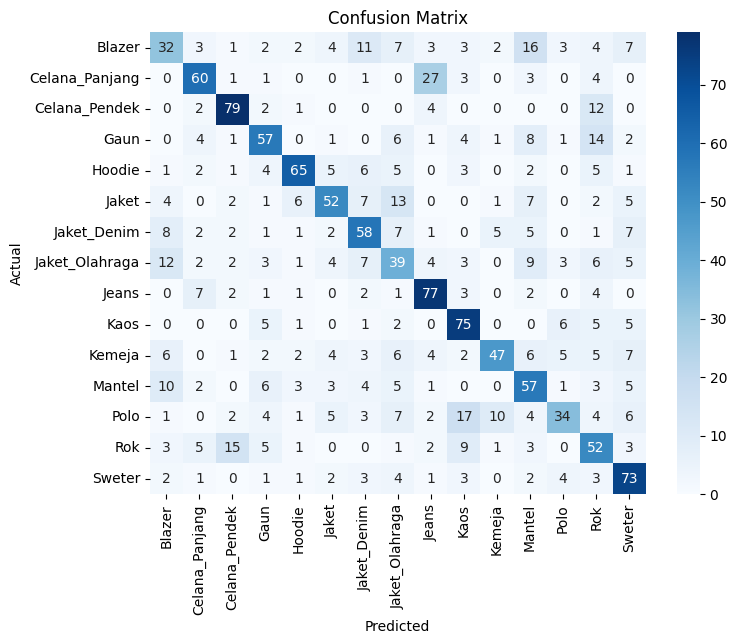

Epoch [6/20], Train Loss: 1.0649, Train Accuracy: 0.6500, Train F1: 0.6478, Precision: 0.6476, Recall: 0.6500
Test Loss: 1.3513, Test Accuracy: 0.5733, Test F1: 0.5702, Precision: 0.5866, Recall: 0.5733
Time taken: 177.54 sec



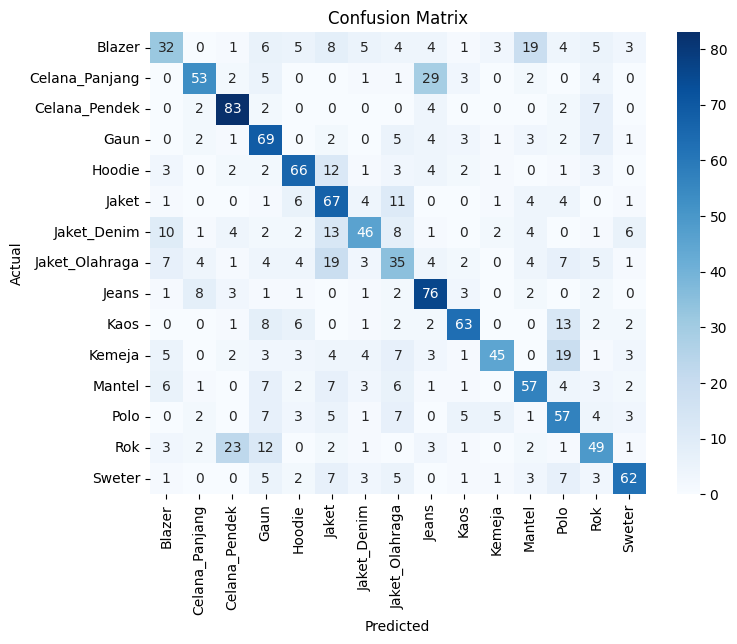

Epoch [7/20], Train Loss: 0.9120, Train Accuracy: 0.7005, Train F1: 0.6986, Precision: 0.6984, Recall: 0.7005
Test Loss: 1.3697, Test Accuracy: 0.5827, Test F1: 0.5822, Precision: 0.6019, Recall: 0.5827
Time taken: 177.39 sec



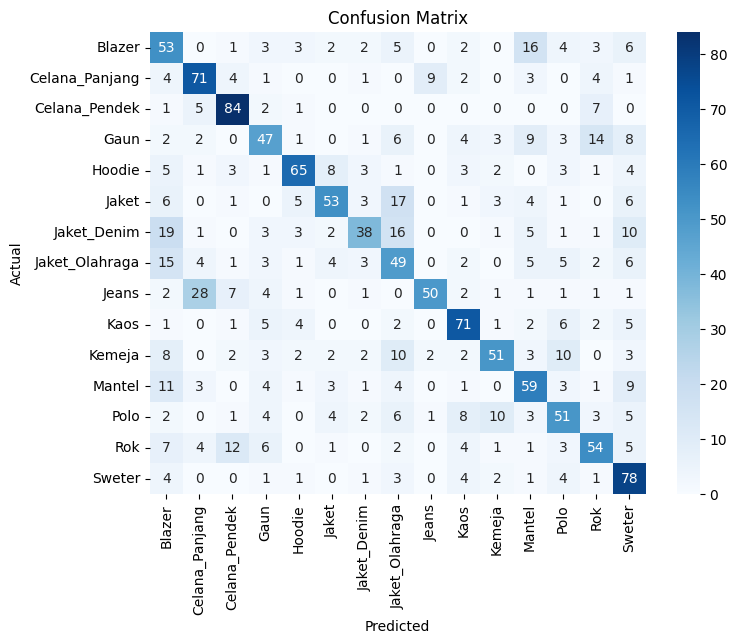

Epoch [8/20], Train Loss: 0.7632, Train Accuracy: 0.7485, Train F1: 0.7475, Precision: 0.7475, Recall: 0.7485
Test Loss: 1.3434, Test Accuracy: 0.6000, Test F1: 0.5918, Precision: 0.6078, Recall: 0.6000
Time taken: 178.09 sec



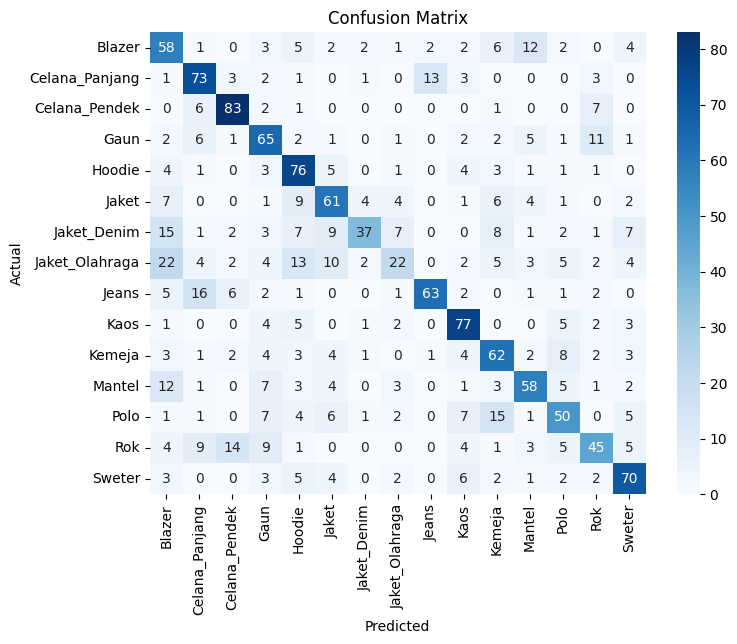

Epoch [9/20], Train Loss: 0.6237, Train Accuracy: 0.7950, Train F1: 0.7941, Precision: 0.7939, Recall: 0.7950
Test Loss: 1.3672, Test Accuracy: 0.5980, Test F1: 0.5953, Precision: 0.6052, Recall: 0.5980
Time taken: 177.84 sec



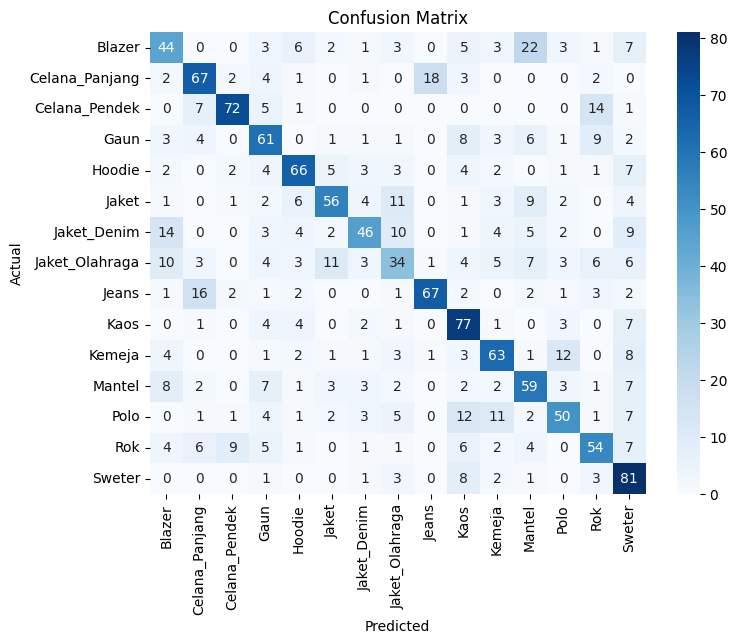

Epoch [10/20], Train Loss: 0.4839, Train Accuracy: 0.8382, Train F1: 0.8379, Precision: 0.8379, Recall: 0.8382
Test Loss: 1.4400, Test Accuracy: 0.5907, Test F1: 0.5857, Precision: 0.5953, Recall: 0.5907
Time taken: 177.74 sec



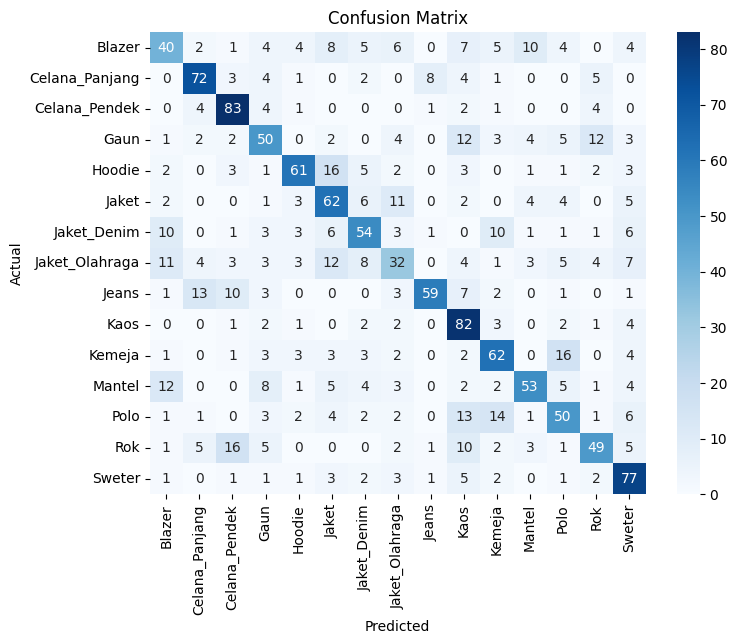

Epoch [11/20], Train Loss: 0.3986, Train Accuracy: 0.8630, Train F1: 0.8628, Precision: 0.8629, Recall: 0.8630
Test Loss: 1.4355, Test Accuracy: 0.5980, Test F1: 0.5944, Precision: 0.6065, Recall: 0.5980
Time taken: 177.17 sec



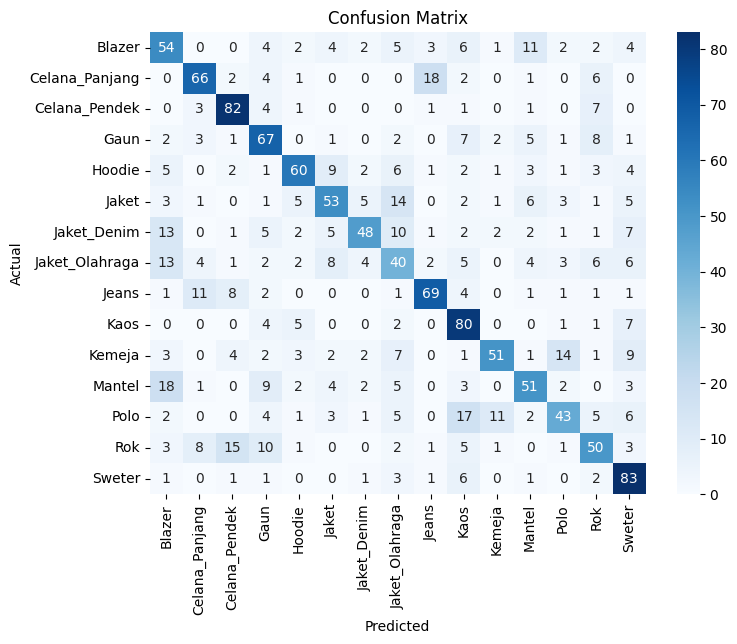

Epoch [12/20], Train Loss: 0.3490, Train Accuracy: 0.8845, Train F1: 0.8842, Precision: 0.8842, Recall: 0.8845
Test Loss: 1.4710, Test Accuracy: 0.6053, Test F1: 0.6027, Precision: 0.6077, Recall: 0.6053
Time taken: 178.21 sec



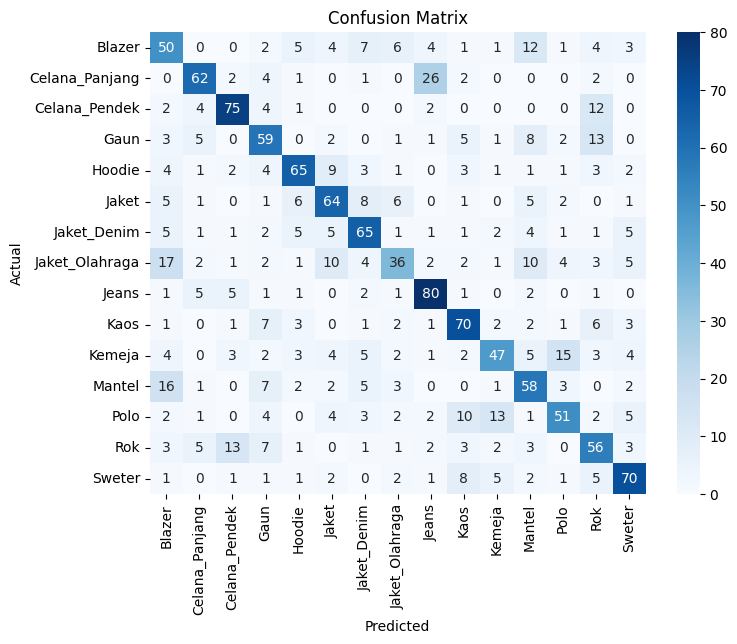

Epoch [13/20], Train Loss: 0.2970, Train Accuracy: 0.8990, Train F1: 0.8989, Precision: 0.8989, Recall: 0.8990
Test Loss: 1.5310, Test Accuracy: 0.6113, Test F1: 0.6106, Precision: 0.6150, Recall: 0.6113
Time taken: 177.76 sec



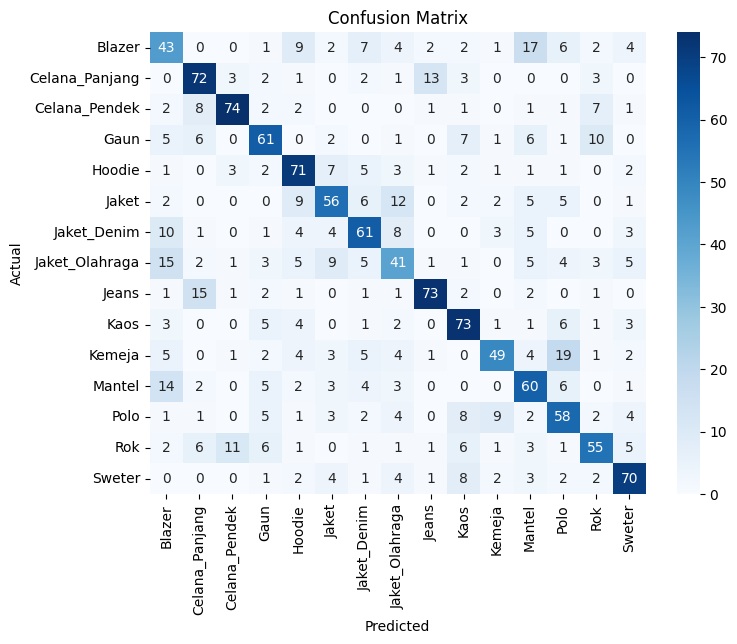

Epoch [14/20], Train Loss: 0.2661, Train Accuracy: 0.9070, Train F1: 0.9068, Precision: 0.9069, Recall: 0.9070
Test Loss: 1.5561, Test Accuracy: 0.6100, Test F1: 0.6080, Precision: 0.6176, Recall: 0.6100
Time taken: 177.22 sec



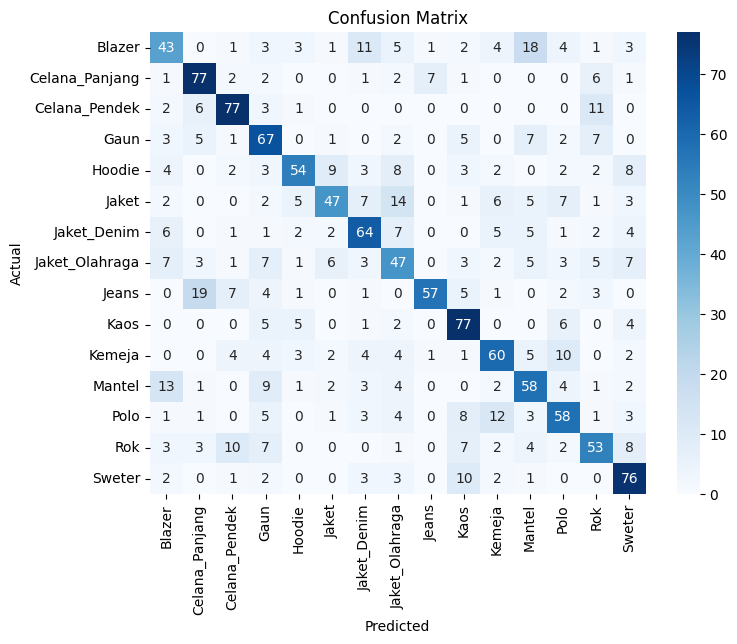

Epoch [15/20], Train Loss: 0.2371, Train Accuracy: 0.9225, Train F1: 0.9225, Precision: 0.9225, Recall: 0.9225
Test Loss: 1.7189, Test Accuracy: 0.5853, Test F1: 0.5862, Precision: 0.5995, Recall: 0.5853
Time taken: 177.65 sec



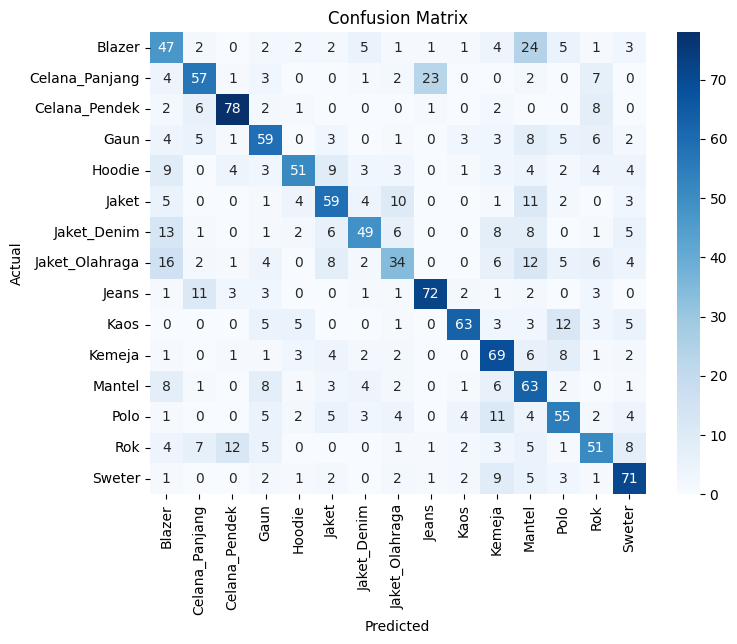

Epoch [16/20], Train Loss: 0.2235, Train Accuracy: 0.9260, Train F1: 0.9259, Precision: 0.9260, Recall: 0.9260
Test Loss: 1.6712, Test Accuracy: 0.6047, Test F1: 0.6023, Precision: 0.6112, Recall: 0.6047
Time taken: 177.26 sec



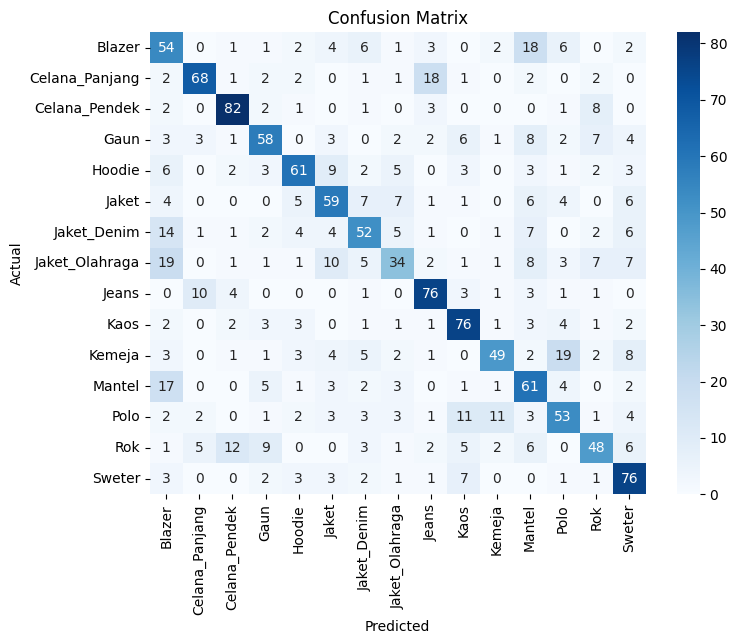

Epoch [17/20], Train Loss: 0.1946, Train Accuracy: 0.9380, Train F1: 0.9379, Precision: 0.9379, Recall: 0.9380
Test Loss: 1.7512, Test Accuracy: 0.6007, Test F1: 0.5954, Precision: 0.6010, Recall: 0.6007
Time taken: 177.93 sec



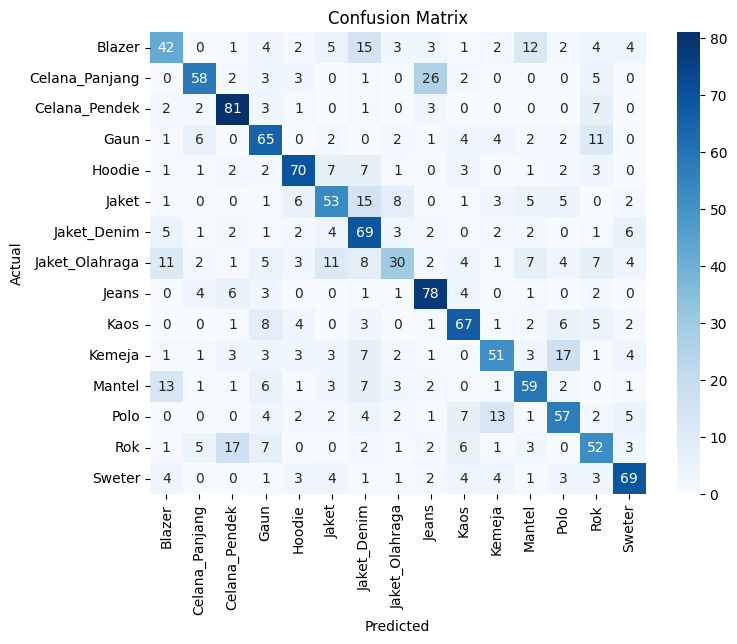

Epoch [18/20], Train Loss: 0.1198, Train Accuracy: 0.9612, Train F1: 0.9612, Precision: 0.9612, Recall: 0.9612
Test Loss: 1.5851, Test Accuracy: 0.6233, Test F1: 0.6218, Precision: 0.6259, Recall: 0.6233
Time taken: 178.04 sec



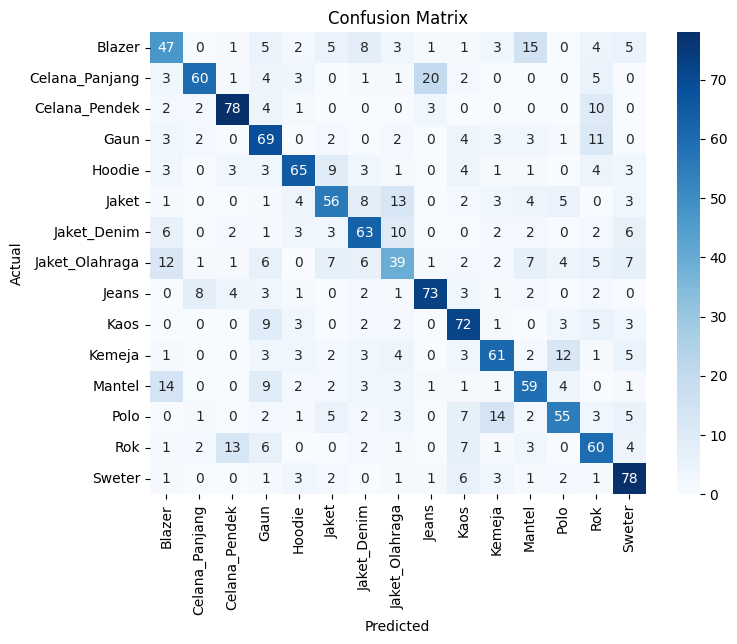

Epoch [19/20], Train Loss: 0.0925, Train Accuracy: 0.9702, Train F1: 0.9701, Precision: 0.9702, Recall: 0.9702
Test Loss: 1.6011, Test Accuracy: 0.6300, Test F1: 0.6264, Precision: 0.6275, Recall: 0.6300
Time taken: 180.12 sec



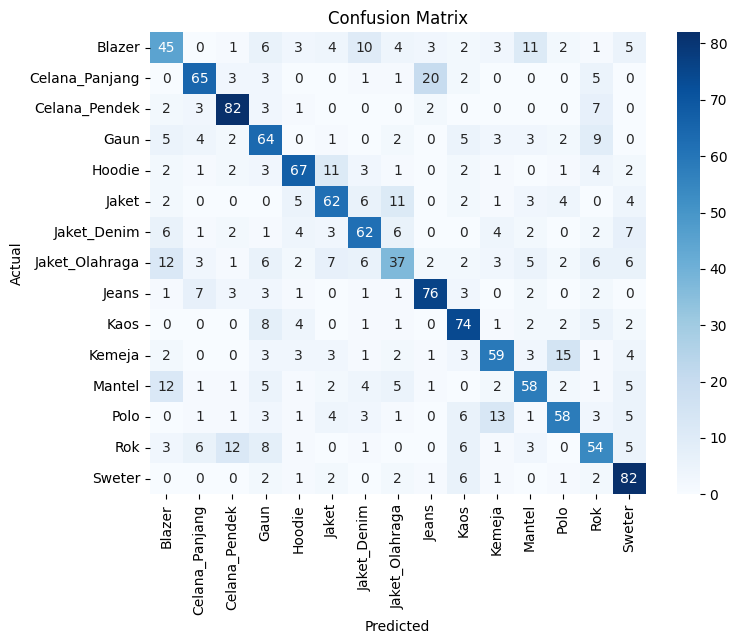

Epoch [20/20], Train Loss: 0.0852, Train Accuracy: 0.9722, Train F1: 0.9721, Precision: 0.9721, Recall: 0.9722
Test Loss: 1.6489, Test Accuracy: 0.6233, Test F1: 0.6209, Precision: 0.6239, Recall: 0.6233
Time taken: 178.13 sec



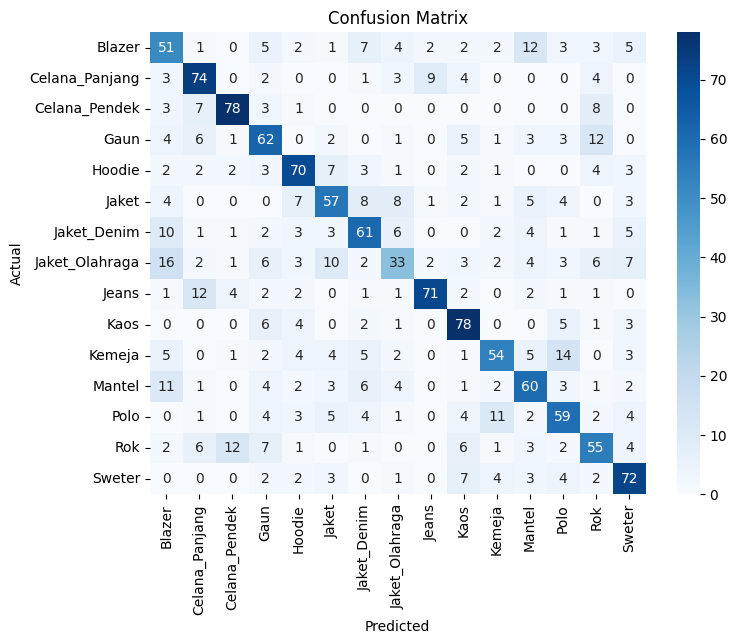

ImprovedCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyR

In [ ]:
train_impoved_cnn_model(improved_cnn_model, improved_train_loader, improved_test_loader, improved_cnn_criterion, improved_cnn_optimizer, improved_cnn_scheduler, improved_test_dataset, num_epochs=20)

Проведем **анализ результатов обучения** и **сравнение с результатами до улучшения бейзлайна**.

**Прогресс по эпохам:**
* До улучшения:
  * Прогресс замедлялся после 5-й эпохи.
  * Метрики на валидации стабилизировались с минимальным приростом (~59–61%).
  * Быстрое переобучение: Train Accuracy стремительно росла, а Test метрики – почти стояли на месте.
* После улучшения:
  * Обучение стало более плавным и контролируемым.
  * Валидационная точность улучшалась до 63% (максимум на эпохе 19).
  * Метрики стали более сбалансированными между обучением и тестом.

**Матрица ошибок:**
* До улучшения:
  * Много пересечений между классами.
  * Несколько особенно слабых строк (например, классы с сильной путаницей).
* После улучшения:
  * Больше выраженной диагонали — модель лучше различает классы.
  * Уменьшилось количество явных промахов (в т.ч. «размазанных» по всей строке).
  * Например, класс 2, 3, 9 теперь предсказывается значительно стабильнее.

**Выводы:**
* Улучшения бейзлайна были эффективны — достигнута лучшая обобщающая способность, более высокая точность, а также повышенная устойчивость к переобучению.
* Модель стала более надежной и лучше справляется с различием между классами.



Инициализируем улучшенную кастомную трансформерную модель с заданными параметрами (размер изображения, патча, эмбеддинга, глубина, число голов, dropout) для классификации на 15 классов и переносим её на устройство.

In [ ]:
impoved_transfer_model = lib_6.VisionTransformer(
    img_size=224,
    patch_size=8,
    in_channels=3,
    num_classes=15,
    emb_size=256,
    depth=4,
    num_heads=8,
    dropout=0.2
).to(device)

Создаём оптимизатор AdamW с заданным learning rate и weight decay. Настраиваем scheduler с warmup: в первые 3 эпохи learning rate постепенно увеличивается, затем экспоненциально уменьшается. Задаём функцию потерь CrossEntropyLoss для классификации.

In [ ]:
impoved_transfer_optimizer = optim.AdamW(impoved_transfer_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler with warmup
def lr_lambda(epoch):
    warmup_epochs = 3
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 0.9 ** (epoch - warmup_epochs)
improved_transfer_scheduler = optim.lr_scheduler.LambdaLR(impoved_transfer_optimizer, lib_6.lr_lambda)

impoved_transfer_criterion = nn.CrossEntropyLoss()

Запускаем обучение улучшенной кастомной трансформерной модели.

Epoch [1/10], Train Loss: 2.0967, Train Accuracy: 0.3437, Train F1: 0.3390, Train Precision: 0.3374, Train Recall: 0.3437
Test Accuracy: 0.4740, Test F1: 0.4658, Test Precision: 0.4831, Test Recall: 0.4740


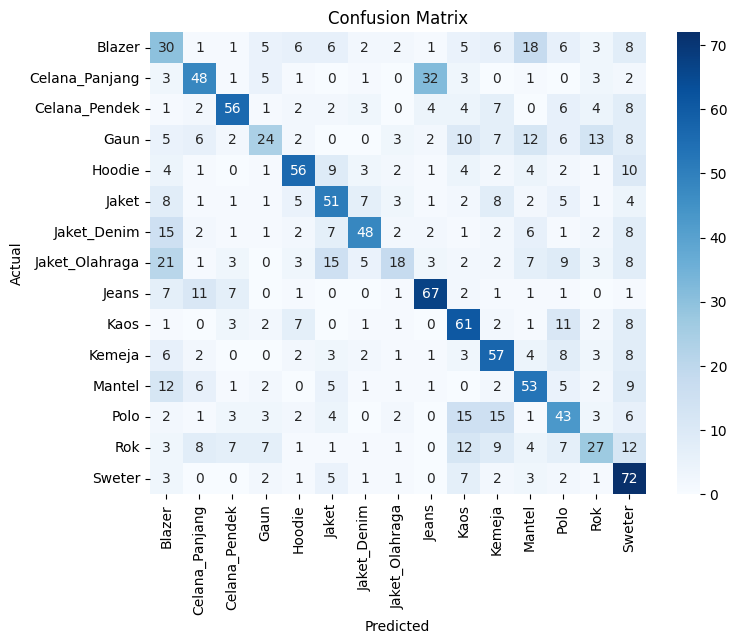

Time taken for epoch: 122.14 sec

Epoch [2/10], Train Loss: 1.4160, Train Accuracy: 0.5538, Train F1: 0.5504, Train Precision: 0.5494, Train Recall: 0.5538
Test Accuracy: 0.5640, Test F1: 0.5626, Test Precision: 0.5721, Test Recall: 0.5640


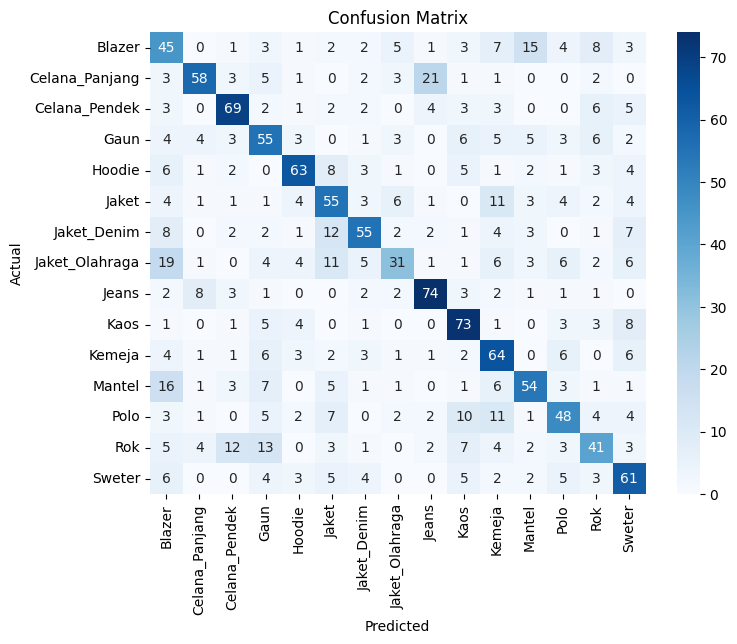

Time taken for epoch: 120.40 sec

Epoch [3/10], Train Loss: 1.0273, Train Accuracy: 0.6885, Train F1: 0.6870, Train Precision: 0.6867, Train Recall: 0.6885
Test Accuracy: 0.5800, Test F1: 0.5749, Test Precision: 0.5926, Test Recall: 0.5800


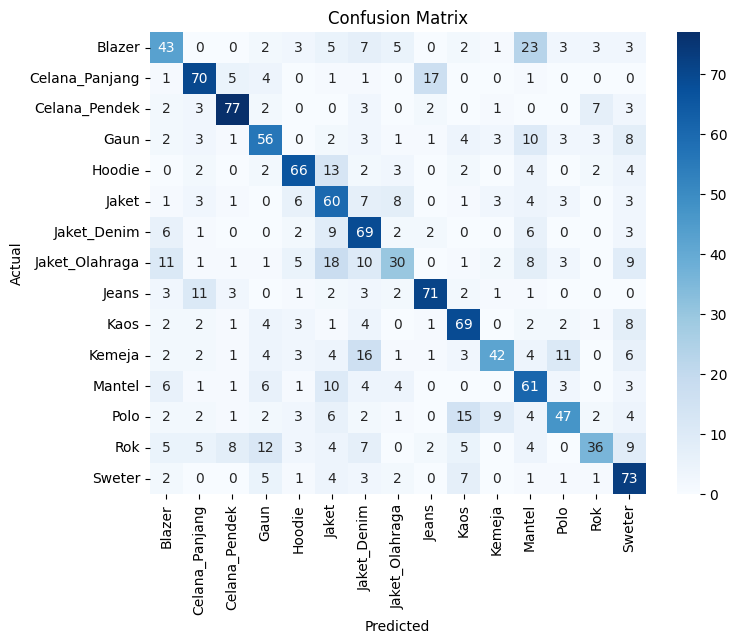

Time taken for epoch: 121.22 sec

Epoch [4/10], Train Loss: 0.6893, Train Accuracy: 0.8038, Train F1: 0.8031, Train Precision: 0.8034, Train Recall: 0.8038
Test Accuracy: 0.5840, Test F1: 0.5855, Test Precision: 0.5990, Test Recall: 0.5840


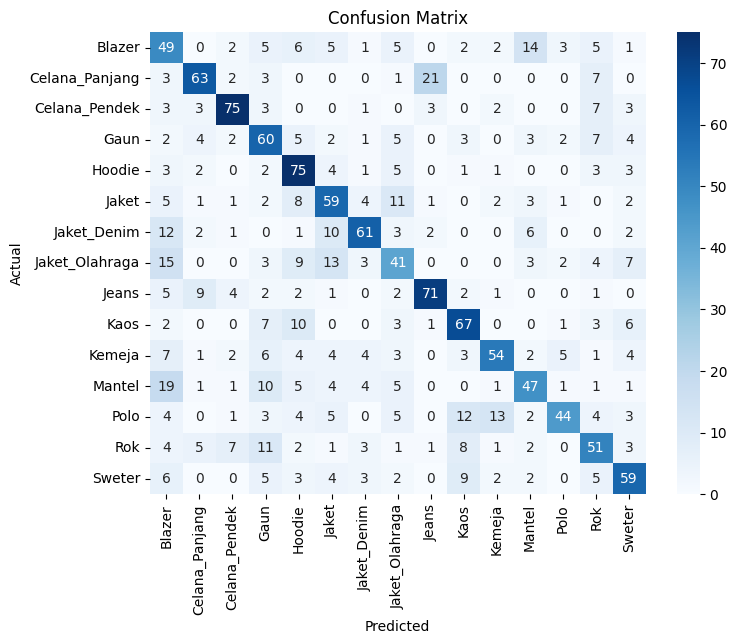

Time taken for epoch: 121.04 sec

Epoch [5/10], Train Loss: 0.4098, Train Accuracy: 0.8963, Train F1: 0.8962, Train Precision: 0.8966, Train Recall: 0.8963
Test Accuracy: 0.6013, Test F1: 0.5990, Test Precision: 0.6062, Test Recall: 0.6013


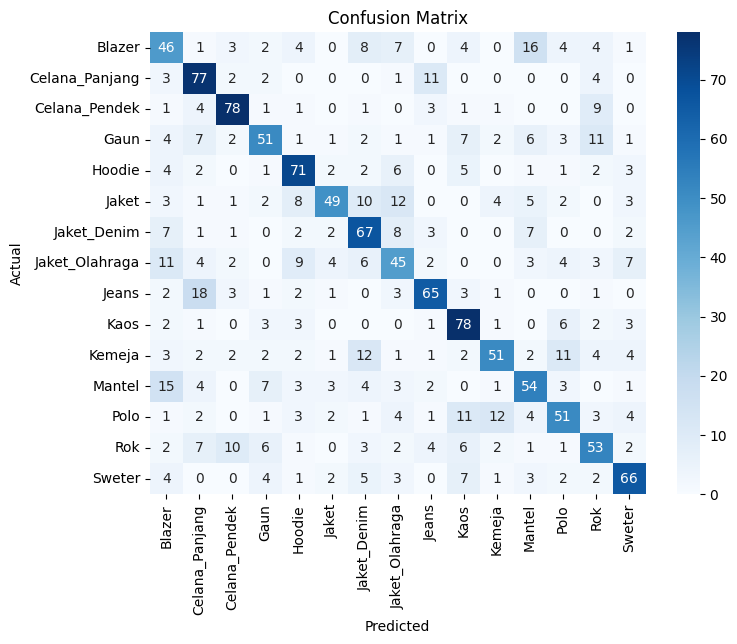

Time taken for epoch: 122.15 sec

Epoch [6/10], Train Loss: 0.2382, Train Accuracy: 0.9513, Train F1: 0.9513, Train Precision: 0.9513, Train Recall: 0.9513
Test Accuracy: 0.6073, Test F1: 0.6085, Test Precision: 0.6196, Test Recall: 0.6073


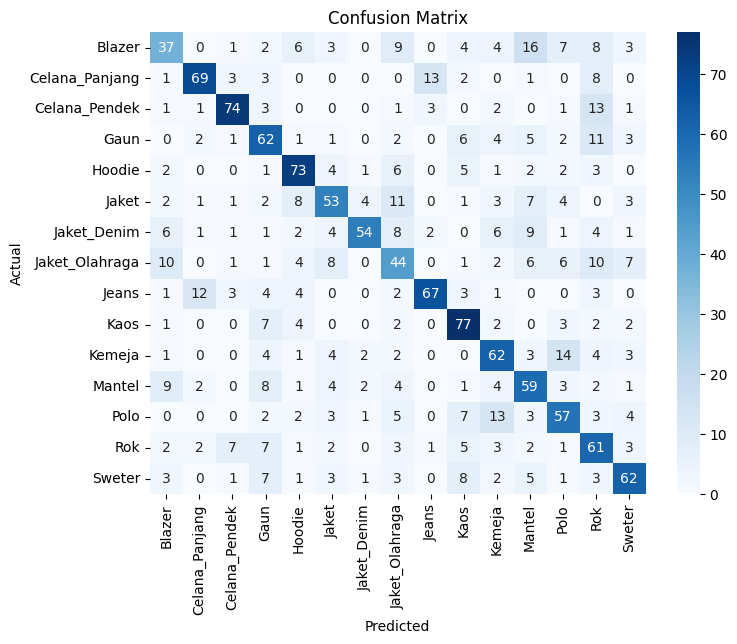

Time taken for epoch: 121.59 sec

Epoch [7/10], Train Loss: 0.1638, Train Accuracy: 0.9675, Train F1: 0.9675, Train Precision: 0.9675, Train Recall: 0.9675
Test Accuracy: 0.5947, Test F1: 0.5933, Test Precision: 0.6035, Test Recall: 0.5947


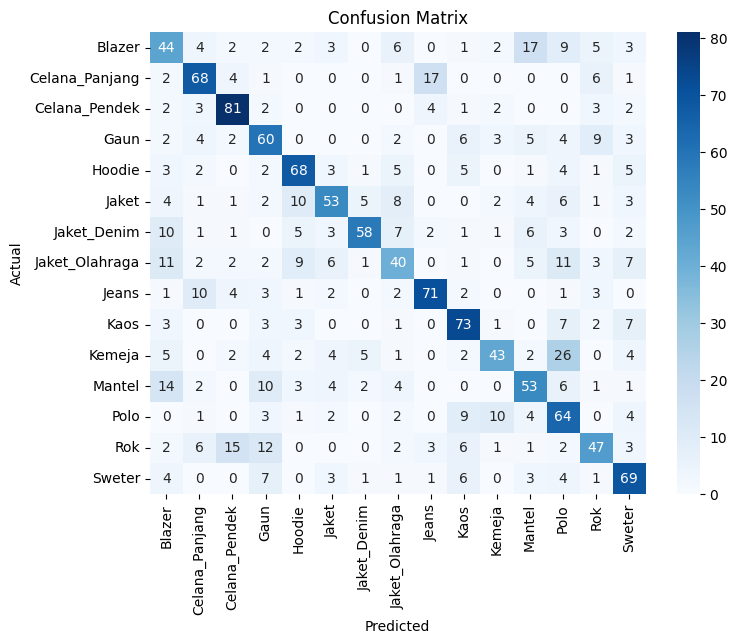

Time taken for epoch: 120.22 sec

Epoch [8/10], Train Loss: 0.0850, Train Accuracy: 0.9897, Train F1: 0.9897, Train Precision: 0.9897, Train Recall: 0.9897
Test Accuracy: 0.6207, Test F1: 0.6170, Test Precision: 0.6182, Test Recall: 0.6207


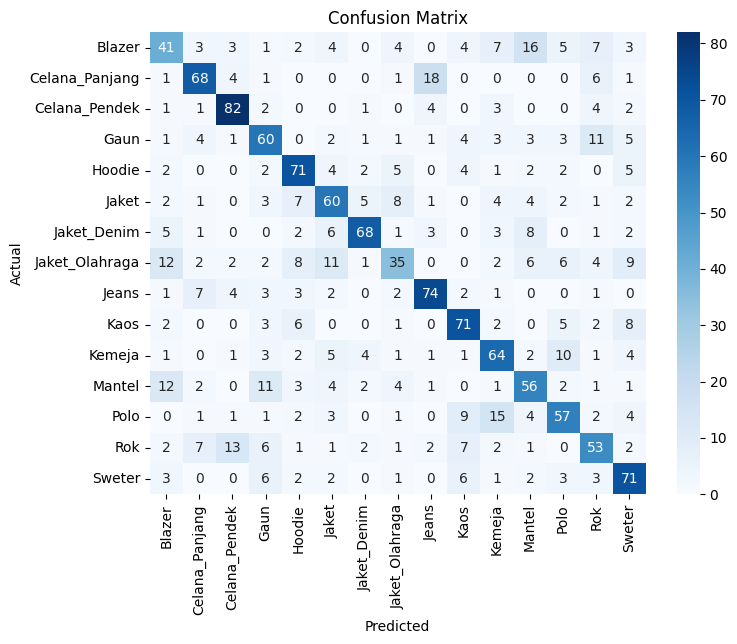

Time taken for epoch: 122.05 sec

Epoch [9/10], Train Loss: 0.0701, Train Accuracy: 0.9900, Train F1: 0.9900, Train Precision: 0.9900, Train Recall: 0.9900
Test Accuracy: 0.6287, Test F1: 0.6259, Test Precision: 0.6283, Test Recall: 0.6287


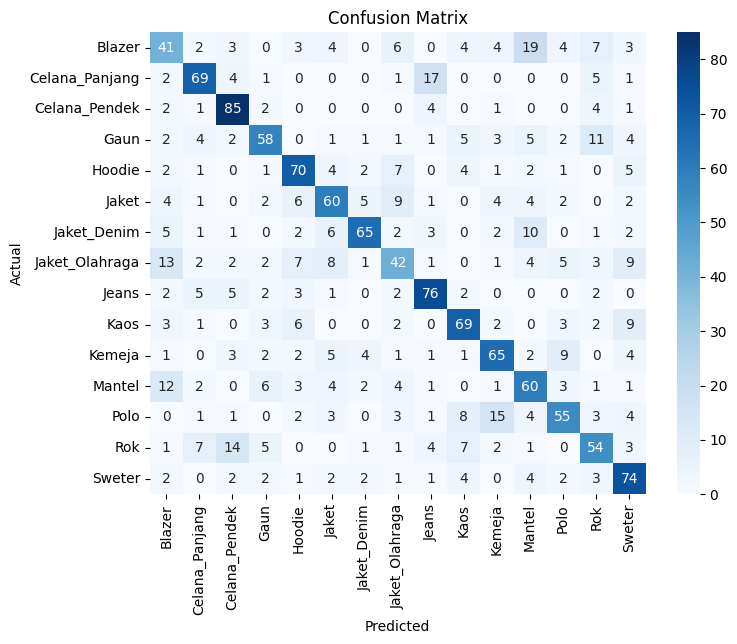

Time taken for epoch: 121.30 sec

Epoch [10/10], Train Loss: 0.0625, Train Accuracy: 0.9903, Train F1: 0.9903, Train Precision: 0.9903, Train Recall: 0.9903
Test Accuracy: 0.6267, Test F1: 0.6222, Test Precision: 0.6245, Test Recall: 0.6267


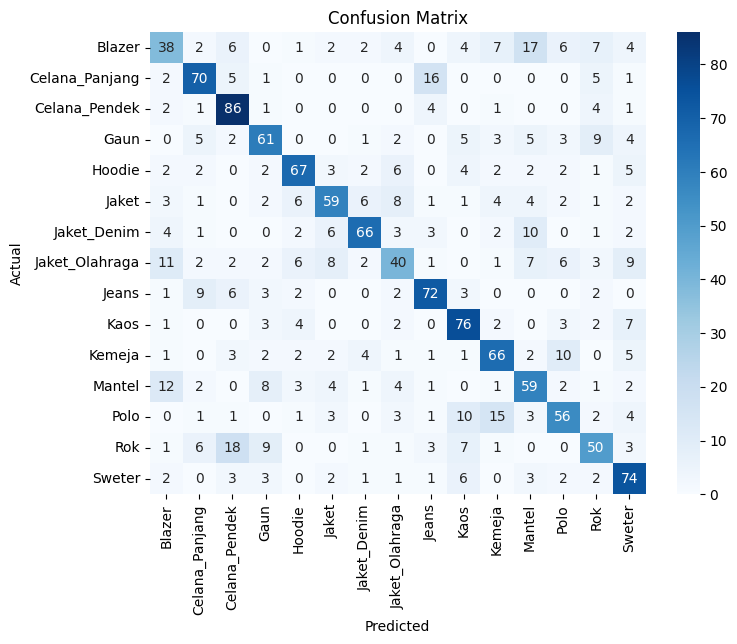

Time taken for epoch: 120.80 sec



In [ ]:
lib_6.train_model(impoved_transfer_model, impoved_train_loader, impoved_test_loader, impoved_transfer_criterion, impoved_transfer_optimizer, impoved_transfer_scheduler, impoved_test_dataset, num_epochs=10)

Проведем **анализ результатов обучения** и **сравнение с результатами до улучшения бейзлайна**.

**Обучение:**
* Модель быстрее выходит на высокую точность и F1.
* Уже на 1 эпохе Train Acc = 0.34 против 0.13 ранее.
* К 10 эпохе — почти идеальное обучение: Train Acc = 0.99, Loss = 0.06.

**Тест:**
* Generalization улучшился заметно:
  * Раньше модель явно переобучалась (разрыв train/test ~30%)
  * Теперь разрыв значительно меньше: Train 99% vs Test 62%.
* F1-score на тесте вырос с 0.43 до 0.63, это существенное улучшение по качеству классификации.

**Матрица ошибок:**
* Сильно более сбалансированная:
  * Классы распознаются увереннее.
  * Нет явных коллапсов или "слепых зон".
  * Меньше "расплывающихся" предсказаний по соседям, чем раньше.

**Выводы:**
* Улучшение бейзлайна дало мощный прирост:
  * +19 п.п. к accuracy на тесте
  * +19 п.п. к F1-score
* Значительно улучшена обобщающая способность
* Модель намного стабильнее и предсказуемее в результатах

## **Выводы**

Проанализируем результаты, полученные всеми алгоритмами. Для этого представим все данные в виде таблицы для удобства анализа.

In [4]:
data = {
    'Модель': ['VGG16 (before)', 'VGG16 (after)', 'ViT-B/16 (after)', 'ViT-B/16 (after)', 'Custom CNN (before)', 'Custom CNN (after)', 'Custom Transformer (before)', 'Custom Transformer (after)'],
    'Accuracy': [0.6833, 0.8293, 0.242, 0.8233, 0.6153, 0.6233, 0.436, 0.6267],
    'F1': [0.6827, 0.8297, 0.2283, 0.8234, 0.6139, 0.6209, 0.4324, 0.6222],
    'Precision': [0.688, 0.8308, 0.2405, 0.8267, 0.6168, 0.6239, 0.4524, 0.6245],
    'Recall': [0.6833, 0.8293, 0.242, 0.8233, 0.6153, 0.6233, 0.436, 0.6267]
}

table = pd.DataFrame(data)
table

Модель  Accuracy      F1  Precision  Recall
0               VGG16 (before)    0.6833  0.6827     0.6880  0.6833
1                VGG16 (after)    0.8293  0.8297     0.8308  0.8293
2             ViT-B/16 (after)    0.2420  0.2283     0.2405  0.2420
3             ViT-B/16 (after)    0.8233  0.8234     0.8267  0.8233
4          Custom CNN (before)    0.6153  0.6139     0.6168  0.6153
5           Custom CNN (after)    0.6233  0.6209     0.6239  0.6233
6  Custom Transformer (before)    0.4360  0.4324     0.4524  0.4360
7   Custom Transformer (after)    0.6267  0.6222     0.6245  0.6267

После анализа представленных результатов видно, что улучшение бейзлайна оказало положительное влияние на все модели, однако степень этого влияния различается. Наиболее впечатляющий прирост наблюдается у кастомных моделей — как у сверточной (CNN), так и у трансформерной. Изначально они демонстрировали относительно скромные показатели (в районе 40–45% точности на тесте), однако после улучшения уверенно преодолели порог в 60%, а трансформерная модель и вовсе приблизилась к 63%. Это говорит о том, что изначальная настройка бейзлайна значительно сдерживала потенциал архитектуры, и после внесения изменений (возможно, улучшение аугментаций, оптимизации, регулирований или структуры данных) модели смогли раскрыться гораздо полнее.

Более зрелые и мощные архитектуры, такие как VGG16 и ViT-B/16, показали высокие результаты уже до улучшений, но всё равно выиграли от оптимизаций. У VGG16 рост составил около 4.6% в точности на тесте, а у ViT прирост оказался менее выраженным, что может свидетельствовать о близости изначального состояния к оптимальному для этой модели. Тем не менее, ViT всё равно оказался лидером среди всех моделей по абсолютным значениям метрик, демонстрируя максимальную стабильность и общую сбалансированность результатов.

Таким образом, можно заключить, что улучшения бейзлайна были особенно критичны для кастомных моделей, позволив им выйти на уровень качества, сравнимый с промышленными решениями. Для предобученных моделей эти улучшения сыграли скорее роль дополнительной доводки, а не ключевого фактора успеха, однако даже в этом случае они обеспечили ощутимый прирост.